In [1]:
import sys
import os
import wandb
import torch
import numpy as np
import json

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
#import pandas as pd

from ml_collections import ConfigDict

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Base.lla import dgala
from Base.utilities import *

from elliptic_files.train_elliptic import train_elliptic,generate_data,samples_param
from elliptic_files.FEM_Solver import FEMSolver
from elliptic_files.elliptic_mcmc import *
from elliptic_files.utilities import *
from elliptic_files.physics_informed_gp import EllipticPIGP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tiaming Experiment

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

In [9]:
import arviz as az
chain_fem = [np.load(f'./results/FEM_eval_kl{2}_var0.0001_{i}.npy') for i in range(4)]


In [8]:
chain_fem = [np.load(f'./results/FEM_kl{5}_var0.0001_{i}.npy') for i in range(4)]

chains = np.stack(chain_fem, axis=0)

print(chains.shape)  

idata = az.from_dict(posterior={"param": chains})
# Effective sample size
ess = az.ess(idata)
print("ESS:\n", ess)

# R-hat statistic
rhat = az.rhat(idata)
print("R-hat:\n", rhat)

(4, 1000000, 5)
ESS:
 <xarray.Dataset> Size: 80B
Dimensions:      (param_dim_0: 5)
Coordinates:
  * param_dim_0  (param_dim_0) int64 40B 0 1 2 3 4
Data variables:
    param        (param_dim_0) float64 40B 813.8 814.0 813.9 988.3 1.216e+03
R-hat:
 <xarray.Dataset> Size: 80B
Dimensions:      (param_dim_0: 5)
Coordinates:
  * param_dim_0  (param_dim_0) int64 40B 0 1 2 3 4
Data variables:
    param        (param_dim_0) float64 40B 1.007 1.007 1.007 1.006 1.005


In [4]:
# Example data
bins = 80
NN_config = [500,250,250,250]
GP_config = [25,100,100,100]
KLs = [2,3,4,5]


nn_results = {}
dgala_results = {}

gp_results = {}
gp_marginal_results = {}


for nn_config,gp_config,kl in zip(NN_config,GP_config,KLs):
    nn_results[f"kl_{kl}"]={}
    gp_results[f"kl_{kl}"]={}
    # dgala_results[f"kl_{kl}"]={}
    # gp_marginal_results[f"kl_{kl}"]={}

    eval = samples_param(100,kl)

    obs_points, _ = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)
    obs_points = torch.tensor(obs_points)
    
    if kl >2:
        model_specific = f"_hl2_nn100_s4000_batch{nn_config}_kl{kl}"
    else:
        model_specific = f"_hl2_nn20_s{nn_config}_batch100_kl{kl}"


    path_nn_model = f"./models/elliptic"+model_specific+".pth"
    #path_dgala_model = f"./models/elliptic_dgala"+model_specific+".pth"


    # nn_post_eval = stat_ar(nn_post_eval, every=5000)[-1]
    # gp_post_eval = stat_ar(gp_post_eval, every=5000)[-1]

    nn_surrogate_model = torch.load(path_nn_model)
    nn_surrogate_model.eval()

    # llp = torch.load(path_dgala_model, map_location=device)
    # llp.model.set_last_layer("output_layer")  # Re-register hooks
    # llp._device = device

    data_training = pigp_training_data_generation(gp_config,6,kl,device)

    elliptic_gp = torch.load(f"./models/elliptic_pigp__spatial6_nsol{gp_config}_kl{kl}.pt")

    # elliptic_gp = EllipticPIGP(data_training,device=device)
    # elliptic_gp.optimize_mll()
    # torch.save(elliptic_gp, f"./models/elliptic_pigp__spatial6_nsol{gp_config}_kl{kl}.pt.pt")


    times_nn,times_gp = [], []
    times_dgala,times_gp_marginal = [], []
    for evl in eval:
        theta = torch.tensor(evl).reshape(1,-1)

        data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()
        
        train_timer = Timer(use_gpu=True)
        train_timer.start()
        surg = nn_surrogate_model.u(data)
        ttrain = train_timer.stop()
        times_nn.append(ttrain)

        # train_timer = Timer(use_gpu=True)
        # train_timer.start()
        # surg,_ = llp(data)
        # ttrain = train_timer.stop()
        # times_dgala.append(ttrain)

        train_timer = Timer(use_gpu=True)
        train_timer.start()
        mean = elliptic_gp.prediction(theta,var=False)
        ttrain = train_timer.stop()
        times_gp.append(ttrain)

        # train_timer = Timer(use_gpu=True)
        # train_timer.start()
        # mean = elliptic_gp.prediction(theta,var=True)
        # ttrain = train_timer.stop()
        # times_gp_marginal.append(ttrain)


    nn_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_nn),np.std(times_nn))
   # dgala_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_dgala),np.std(times_dgala))

    gp_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp),np.std(times_gp))
    #gp_marginal_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp_marginal),np.std(times_gp_marginal))

    # samples_th = torch.normal(mean=0, std=1, size=(10000,kl))

    # fem_solver = FEMSolver(np.zeros(kl),M=kl,vert=50)
    # error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,samples_th, device)
    # nn_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    # error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,samples_th, device, gp=True)
    # gp_results[f"kl_{kl}"]["m0_error"] = error_mcmc
    nn_ind_res = {"w1":[],"post":[],"bound":[]}
    gp_ind_res = {"w1":[],"post":[],"bound":[]}
    for i in range(4):
        chain_fem = np.load(f'./results/FEM_kl{kl}_var0.0001_{i}.npy')


        fem_solver = FEMSolver(np.zeros(kl),M=kl,vert=50)
        error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device)
        nn_ind_res["bound"].append(error_mcmc)

        error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device, gp=True)
        gp_ind_res["bound"].append(error_mcmc)

        chain_nn = np.load(f'./results/NN'+model_specific+f'_var0.0001_{i}.npy')
        nn_post_eval = np.load(f"./results/mcmc_da_nn"+model_specific+f"_0.0001_{i}.npy")

        chain_gp = np.load(f"./results/PIGP_mean_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        gp_post_eval = np.load(f"./results/mcmc_da_pigp_mean_spatial6_nsol{gp_config}_kl{kl}_0.0001_{i}.npy")

        # w1_nn = discrete_W1(chain_nn,chain_fem)
        # nn_ind_res["w1"].append(w1_nn)
        
        # w1_gp = discrete_W1(chain_gp,chain_nn)
        # gp_ind_res["w1"].append(w1_gp)

        nn_ind_res["post"].append(nn_post_eval.sum()/nn_post_eval.shape[-1])
        gp_ind_res["post"].append(gp_post_eval.sum()/gp_post_eval.shape[-1])

        # solver_val = np.load(f"./results/mcmc_da_pigp_mean_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_pigp_mean_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # gp_ind_res["bound"].append(mean_dif)

        # solver_val = np.load(f"./results/mcmc_da_nn_lh_solver"+ model_specific+ f"_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_nn_lh_nn"+ model_specific+ f"_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # nn_ind_res["bound"].append(mean_dif)


    # nn_mean, nn_std = (np.mean(nn_ind_res["w1"]),np.std(nn_ind_res["w1"]))
    # gp_mean, gp_std = (np.mean(gp_ind_res["w1"]),np.std(gp_ind_res["w1"]))

    # nn_results[f"kl_{kl}"]["w1"] = (nn_mean, nn_std)

    # gp_results[f"kl_{kl}"]["w1"] = (gp_mean, gp_std)

    
    nn_mean, nn_std = (np.mean(nn_ind_res["post"]),np.std(nn_ind_res["post"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["post"]), np.std(gp_ind_res["post"]))

    nn_results[f"kl_{kl}"]["post_eval"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["post_eval"] = (gp_mean, gp_std)

    
    nn_mean, nn_std = (np.mean(nn_ind_res["bound"]),np.std(nn_ind_res["bound"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["bound"]), np.std(gp_ind_res["bound"]))

    nn_results[f"kl_{kl}"]["m_error"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["m_error"] = (gp_mean, gp_std)


    # nn_mean, nn_std = (np.mean(nn_ind_res["bound"]),np.std(nn_ind_res["bound"]))
    # gp_mean, gp_std = (np.mean(gp_ind_res["bound"]), np.std(gp_ind_res["bound"]))

    # nn_results[f"kl_{kl}"]["bound"] = (nn_mean, nn_std)

    # gp_results[f"kl_{kl}"]["bound"] = (gp_mean, gp_std)

    # error_mcmc = error_norm_mean(nn_surrogate_model, elliptic_gp,obs_points ,torch.tensor(chain_fem)[-10000:,:], device,solver=False, gp=False)
    # gp_results[f"kl_{kl}"]["nn_gp"] = error_mcmc

In [6]:
nn_results

{'kl_2': {'eval_time': (5.945231881923974e-05, 2.0103373237357935e-05),
  'post_eval': (0.95649, 0.0005702192560761151),
  'm_error': (0.0014479539697548835, 1.6534971320796405e-06)},
 'kl_3': {'eval_time': (0.00013220596069004386, 3.537019725718661e-05),
  'post_eval': (0.951765, 0.009100081043595144),
  'm_error': (0.0006476986860524759, 1.111857675212072e-05)},
 'kl_4': {'eval_time': (0.000125039761478547, 2.8846909648480494e-05),
  'post_eval': (0.903785, 0.0052547954289391815),
  'm_error': (0.0007827476325607004, 2.2851147955526705e-05)},
 'kl_5': {'eval_time': (0.00012687697075307368, 3.278359050731835e-05),
  'post_eval': (0.90206, 0.024623870532473176),
  'm_error': (0.002078866298780341, 0.0012547963985724776)}}

In [7]:
gp_results

{'kl_2': {'eval_time': (4.977214091923088e-05, 1.3345982582192023e-05),
  'post_eval': (0.92784, 0.00037762415176998256),
  'm_error': (0.0013895171969603754, 1.5397383960537242e-05)},
 'kl_3': {'eval_time': (0.00011268375994404777, 2.270226236845166e-05),
  'post_eval': (0.9057599999999999, 0.006952093209962037),
  'm_error': (0.0019138359241645275, 0.00014997937670077987)},
 'kl_4': {'eval_time': (0.00010814383975230157, 1.8230258662793875e-05),
  'post_eval': (0.763845, 0.012631012429730245),
  'm_error': (0.0032993026594040726, 0.00016210208134493574)},
 'kl_5': {'eval_time': (0.00010787793959025293, 1.7831517216775325e-05),
  'post_eval': (0.875235, 0.01585645846335179),
  'm_error': (0.0024012455410733716, 0.00033187417943528744)}}

# Marginal results

In [2]:
# Example data
bins = 80
NN_config = [500,250,250,250]
GP_config = [25,100,100,100]
KLs = [2,3,4,5]



dgala_results = {}
gp_marginal_results = {}


for nn_config,gp_config,kl in zip(NN_config,GP_config,KLs):
    dgala_results[f"kl_{kl}"]={}
    gp_marginal_results[f"kl_{kl}"]={}

    eval = samples_param(100,kl)

    obs_points, _ = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=kl,vert=50)
    obs_points = torch.tensor(obs_points)
    
    if kl >2:
        model_specific = f"_hl2_nn100_s4000_batch{nn_config}_kl{kl}"
    else:
        model_specific = f"_hl2_nn20_s{nn_config}_batch100_kl{kl}"


    path_dgala_model = f"./models/elliptic_dgala"+model_specific+".pth"


    # nn_post_eval = stat_ar(nn_post_eval, every=5000)[-1]
    # gp_post_eval = stat_ar(gp_post_eval, every=5000)[-1]


    llp = torch.load(path_dgala_model, map_location=device)
    llp.model.set_last_layer("output_layer")  # Re-register hooks
    llp._device = device

    data_training = pigp_training_data_generation(gp_config,6,kl,device)

    elliptic_gp = torch.load(f"./models/elliptic_pigp__spatial6_nsol{gp_config}_kl{kl}.pt")

    times_dgala,times_gp_marginal = [], []
    for evl in eval:
        theta = torch.tensor(evl).reshape(1,-1)

        data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()
        
        train_timer = Timer(use_gpu=True)
        train_timer.start()
        surg,_ = llp(data)
        ttrain = train_timer.stop()
        times_dgala.append(ttrain)

        train_timer = Timer(use_gpu=True)
        train_timer.start()
        mean = elliptic_gp.prediction(theta,var=True)
        ttrain = train_timer.stop()
        times_gp_marginal.append(ttrain)


    dgala_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_dgala),np.std(times_dgala))

    gp_marginal_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp_marginal),np.std(times_gp_marginal))

    # samples_th = torch.normal(mean=0, std=1, size=(10000,kl))

    # fem_solver = FEMSolver(np.zeros(kl),M=kl,vert=50)
    # error_mcmc = error_norm_marginal(llp, fem_solver,obs_points ,samples_th, device)
    # dgala_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    # error_mcmc = error_norm_marginal(elliptic_gp, fem_solver,obs_points ,samples_th, device, gp=True)
    # gp_marginal_results[f"kl_{kl}"]["m0_error"] = error_mcmc
    nn_ind_res = {"post":[],"m_error":[]}
    gp_ind_res = {"post":[],"m_error":[]}


    for i in range(2):
        #chain_nn = np.load(f'./results/NN'+model_specific+f'_var0.0001_{i}.npy')
        nn_post_eval = np.load(f"./results/mcmc_da_dgala"+model_specific+f"_0.0001_{i}.npy")

        #chain_gp = np.load(f"./results/PIGP_mean_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        gp_post_eval = np.load(f"./results/mcmc_da_pigp_marginal_spatial6_nsol{gp_config}_kl{kl}_0.0001_{i}.npy")

        # w1_nn = discrete_W1(chain_nn,chain_fem)
        # nn_ind_res["w1"].append(w1_nn)
        
        # w1_gp = discrete_W1(chain_gp,chain_nn)
        # gp_ind_res["w1"].append(w1_gp)

        nn_ind_res["post"].append(nn_post_eval.sum()/nn_post_eval.shape[-1])
        gp_ind_res["post"].append(gp_post_eval.sum()/gp_post_eval.shape[-1])

        # solver_val = np.load(f"./results/mcmc_da_pigp_marginal_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_pigp_marginal_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # gp_ind_res["bound"].append(mean_dif)

        # solver_val = np.load(f"./results/mcmc_da_dgala_lh_solver"+ model_specific+ f"_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_dgala_lh_nn"+ model_specific+ f"_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # nn_ind_res["bound"].append(mean_dif)

        chain_fem = np.load(f'./results/FEM_kl{kl}_var0.0001_{i}.npy')

        fem_solver = FEMSolver(np.zeros(kl),M=kl,vert=50)
        error_mcmc = error_norm_marginal(llp, fem_solver,obs_points ,torch.tensor(chain_fem)[-1000:,:], device)
        nn_ind_res["m_error"].append(error_mcmc)

        error_mcmc = error_norm_marginal(elliptic_gp, fem_solver,obs_points ,torch.tensor(chain_fem)[-1000:,:], device, gp=True)
        gp_ind_res["m_error"].append(error_mcmc)

    # nn_mean, nn_std = (np.mean(nn_ind_res["w1"]),np.std(nn_ind_res["w1"]))
    # gp_mean, gp_std = (np.mean(gp_ind_res["w1"]),np.std(gp_ind_res["w1"]))

    # dgala_results[f"kl_{kl}"]["w1"] = (nn_mean, nn_std)

    # gp_marginal_results[f"kl_{kl}"]["w1"] = (gp_mean, gp_std)
    
    nn_mean, nn_std = (np.mean(nn_ind_res["post"]),np.std(nn_ind_res["post"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["post"]), np.std(gp_ind_res["post"]))

    dgala_results[f"kl_{kl}"]["post_eval"] = (nn_mean, nn_std)
    gp_marginal_results[f"kl_{kl}"]["post_eval"] = (gp_mean, gp_std)

        
    nn_mean, nn_std = (np.mean(nn_ind_res["m_error"]),np.std(nn_ind_res["m_error"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["m_error"]), np.std(gp_ind_res["m_error"]))

    dgala_results[f"kl_{kl}"]["m_error"] = (nn_mean, nn_std)
    gp_marginal_results[f"kl_{kl}"]["m_error"] = (gp_mean, gp_std)

    # error_mcmc = error_norm_mean(nn_surrogate_model, elliptic_gp,obs_points ,torch.tensor(chain_fem)[-10000:,:], device,solver=False, gp=False)
    # gp_results[f"kl_{kl}"]["nn_gp"] = error_mcmc

In [5]:
gp_marginal_results

{'kl_2': {'eval_time': (0.0038865525799337774, 0.003471302196959533),
  'post_eval': (0.92748, 0.0026399999999999757),
  'm_error': (0.0027937666719762945, 2.663242207794894e-05)},
 'kl_3': {'eval_time': (0.05985964047111338, 0.007582746082559203),
  'post_eval': (0.82616, 0.0011400000000000299),
  'm_error': (nan, nan)},
 'kl_4': {'eval_time': (0.099113867249107, 0.11035015433488167),
  'post_eval': (0.67879, 0.010550000000000004),
  'm_error': (0.0043946377542972495, 8.550306953539807e-06)},
 'kl_5': {'eval_time': (0.09051477215107298, 0.06461830118099646),
  'post_eval': (0.84844, 0.0),
  'm_error': (0.0020009650615663817, 0.00031885286092166187)}}

In [6]:
dgala_results

{'kl_2': {'eval_time': (0.0008490107007673942, 0.0005539743285302516),
  'post_eval': (0.95298, 0.0006599999999999939),
  'm_error': (0.006130114310730925, 1.2397256038178435e-05)},
 'kl_3': {'eval_time': (0.0023073360123089513, 0.0007519819512119176),
  'post_eval': (0.95591, 0.0022500000000000298),
  'm_error': (0.0011670056488983405, 3.549340236750167e-06)},
 'kl_4': {'eval_time': (0.002754724707046989, 0.001313195255131698),
  'post_eval': (0.90696, 0.005659999999999998),
  'm_error': (0.001349894505944529, 1.53590317366354e-05)},
 'kl_5': {'eval_time': (0.0028518189094029365, 0.0014680502582075125),
  'post_eval': (0.90675, 0.015949999999999964),
  'm_error': (0.0015742369067400057, 9.043442281182746e-05)}}

# Graphs

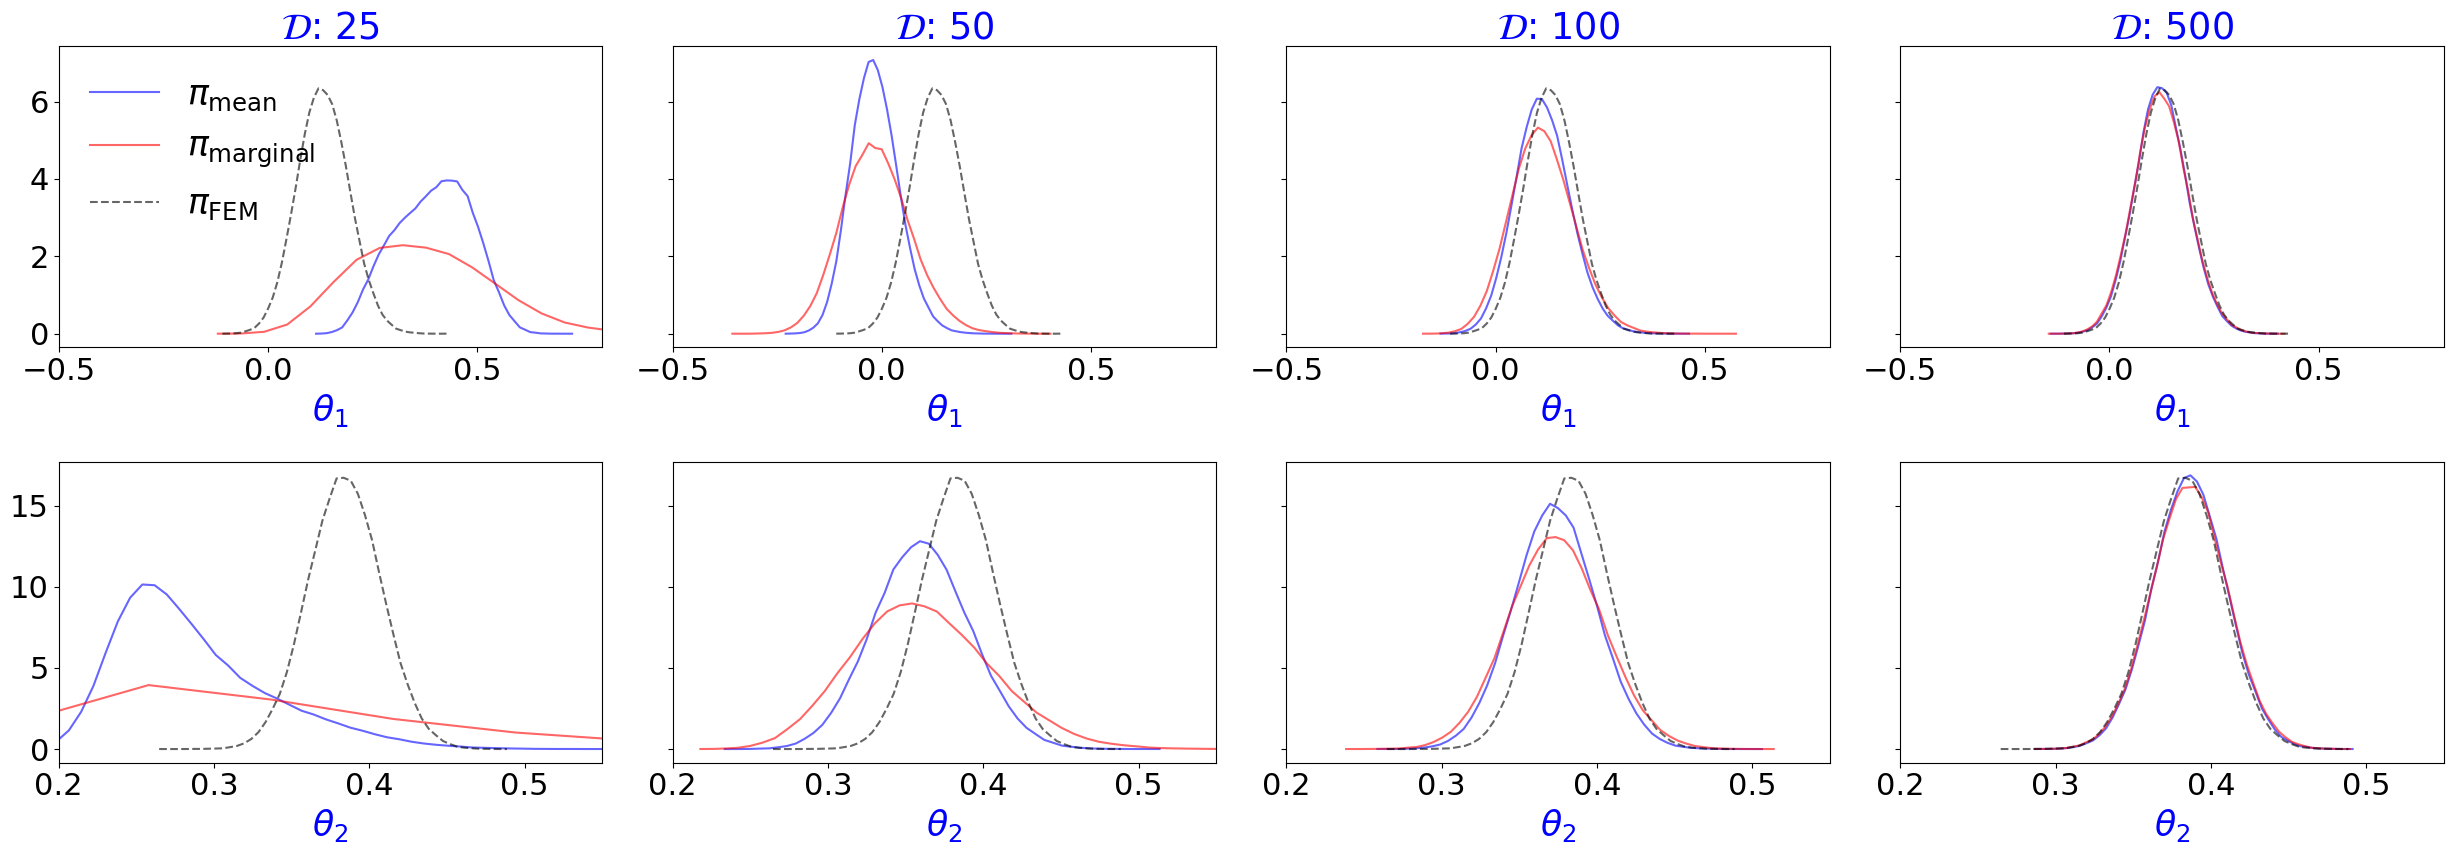

In [33]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#N = [100, 250, 500, 1000, 1500, 2500, 4000, 5000]
N = [25, 50, 100,500]
bins = 50
kl = 2
nn = 20

fig, axs = plt.subplots(2,len(N), figsize=(25, 9), sharey="row", sharex="row")
#fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 22})

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/NN_hl{2}_nn{nn}_s{nobs}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_hl{2}_nn{nn}_s{nobs}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/FEM_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    # axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    # axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)
    axs[0,i].set_xlim((-.5,0.8))
    axs[1,i].set_xlim((0.2,0.55))
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)


axs[0,0].legend(frameon = False, prop={'size': 25},loc='upper left')
# axs[0, 0].legend(
#     frameon=False,
#     prop={'size': 15},
#     loc='upper right',
#     bbox_to_anchor=(3.7, 1)  # Adjust position as needed
# )
#axs[-1,0].set_xlim((-0.3,0.6)),axs[-1,1].set_xlim((0.25,0.5))
plt.tight_layout()
plt.savefig(f"./results/images/elliptic_pd_kl{kl}_{vr}.pdf", bbox_inches='tight') 

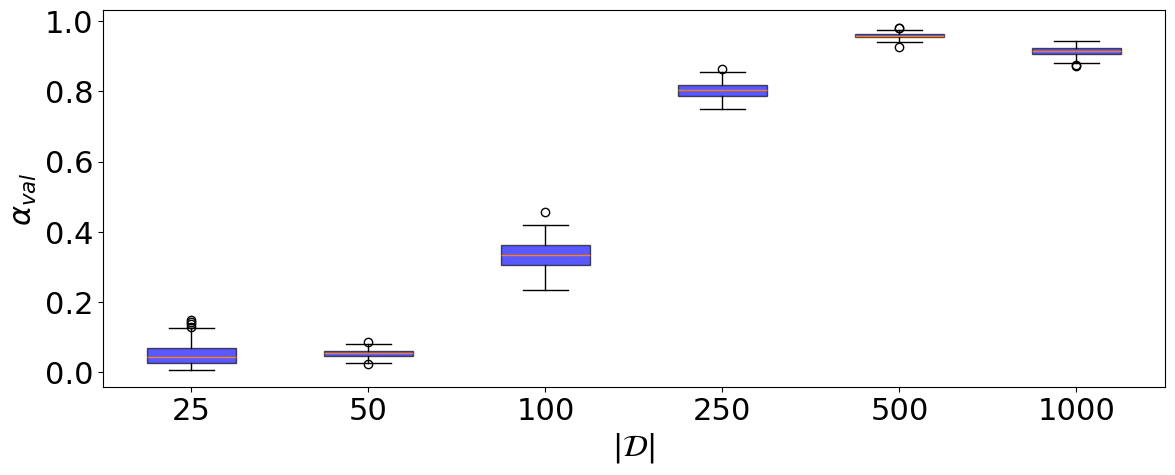

In [8]:
N = [25, 50, 100, 250, 500, 1000]

acceptance_mean_list = np.array([stat_ar(np.load(f"./results/mcmc_da_nn_hl2_nn20_s{n}_kl{kl}_{vr}.npy"),every=500)[-1] for n in N])
cl = ["red", "blue", "green", "orange", "black","orange","tomato"]

fig, axs = plt.subplots(1, figsize=(12, 5), sharex="col")
plt.rcParams.update({'font.size': 15})

bplot = axs.boxplot(acceptance_mean_list.T,patch_artist=True, labels=[str(n) for n in N])  # Transpose to plot along axis 1
#plt.suptitle(f"Acceptance Rate for different NN",color = "blue")
# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor("blue")
    patch.set_alpha(0.65)
    patch.set_linewidth(1)

# Customize the plot
axs.set_xlabel("$|\\mathcal{D}|$")
axs.set_ylabel("$\\alpha_{val}$")
#plt.ylim((0,0.5))
# Save the plotx
plt.savefig(f"./results/images/elliptic_da_ar_kl{kl}_{vr}.pdf")
axs.legend(frameon =False)
plt.tight_layout()
plt.show()

In [11]:

elliptic_gp = torch.load(f"./models/elliptic_pigp__spatial6_nsol{100}_kl{3}.pt")
torch.linalg.cond(elliptic_gp.cov_matrix,p=2)

tensor(1.6637e+11, dtype=torch.float64)

GP Ndata75: max = 0.08046702295541763, min = 0.00022800346778240055, mean=0.008408300578594208
GP Ndata100: max = 0.05977047234773636, min = 0.0002532570797484368, mean=0.008444256149232388


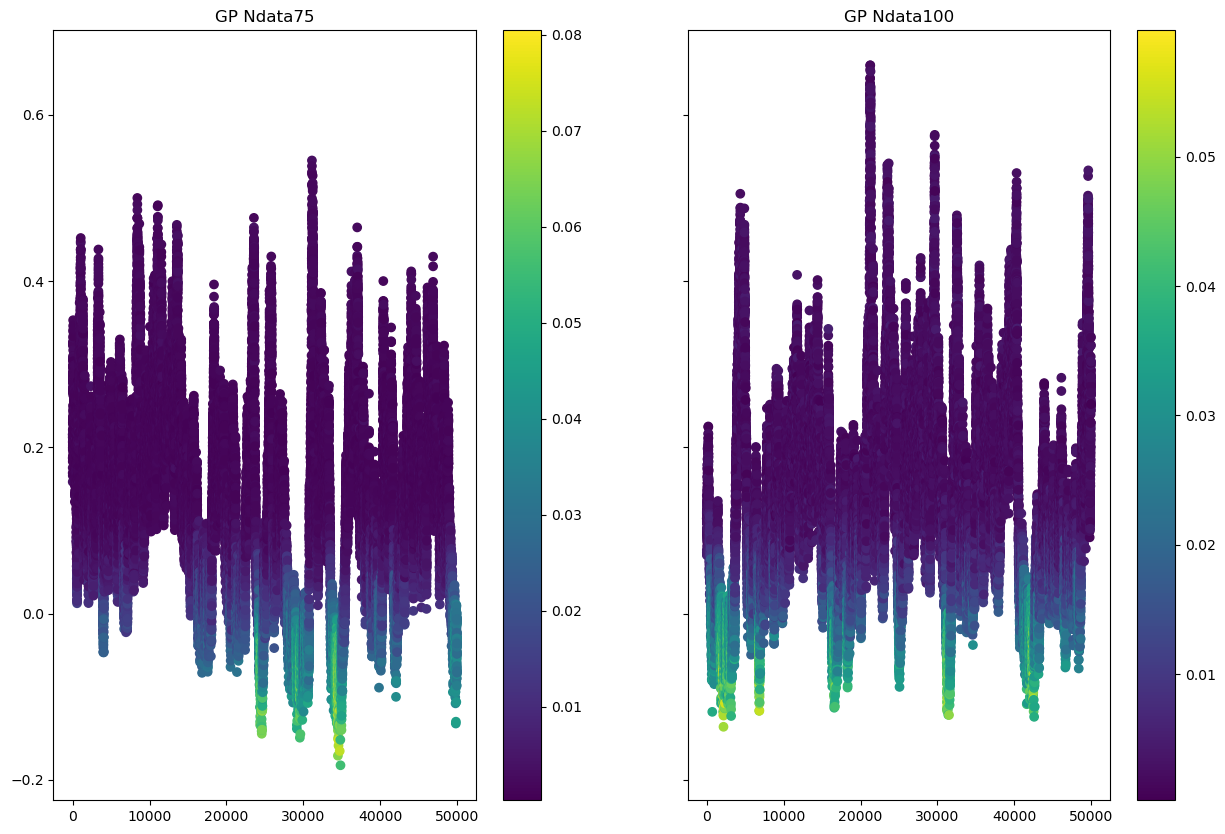

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

kl = 4
for i,gp_config in enumerate([75,100]):

    solver_val = np.load(f"./results/mcmc_da_pigp_mean_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{0}.npy")
    surrogate_val = np.load(f"./results/mcmc_da_pigp_mean_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{0}.npy")
    proposal_thetas = np.load(f"./results/mcmc_da_pigp_mean_proposal_thetas_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{0}.npy")
    acceptance_res = np.load(f"./results/mcmc_da_pigp_mean_spatial6_nsol{gp_config}_kl{kl}_0.0001_{0}.npy")

    dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
    print(f"GP Ndata{gp_config}: max = {dif.max()}, min = {dif.min()}, mean={np.mean(dif)}")
    bar = axs[i].scatter(np.arange(proposal_thetas.shape[0]), proposal_thetas[:,1], c=dif)
    plt.colorbar(bar, ax=axs[i])
    axs[i].set_title(f"GP Ndata{gp_config}")
    

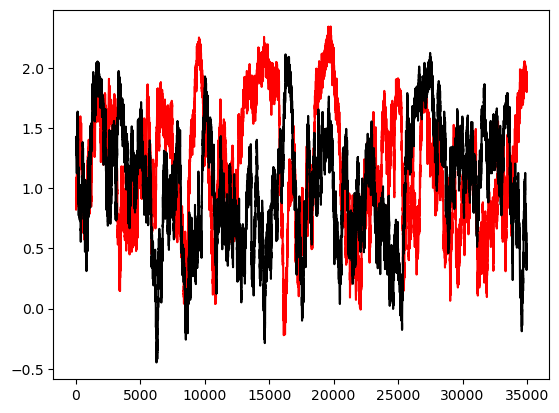

In [14]:
proposal_thetas1 = np.load(f"./results/mcmc_da_pigp_mean_proposal_thetas_spatial6_nsol{75}_kl{kl}_var0.0001_{0}.npy")
proposal_thetas2 = np.load(f"./results/mcmc_da_pigp_mean_proposal_thetas_spatial6_nsol{100}_kl{kl}_var0.0001_{0}.npy")
plt.plot(proposal_thetas1[15000:90000,0],color="red")
plt.plot(proposal_thetas2[15000:900000,0],color="black")


In [107]:
elliptic_gp1 = torch.load(f"./models/elliptic_pigp__spatial6_nsol{75}_kl{4}.pt")
elliptic_gp2 = torch.load(f"./models/elliptic_pigp__spatial6_nsol{100}_kl{4}.pt")

In [108]:
print(elliptic_gp1.kernel_parameter.l,elliptic_gp1.kernel_parameter.sigma)
print(elliptic_gp2.kernel_parameter.l,elliptic_gp2.kernel_parameter.sigma)

print(elliptic_gp1.kernel_spatial.l,elliptic_gp1.kernel_spatial.sigma)
print(elliptic_gp2.kernel_spatial.l,elliptic_gp2.kernel_spatial.sigma)

tensor(4.0617, dtype=torch.float64) tensor(0.8492, dtype=torch.float64)
tensor(4.2497, dtype=torch.float64) tensor(0.8702, dtype=torch.float64)
tensor(0.3456, dtype=torch.float64) tensor(0.8492, dtype=torch.float64)
tensor(0.3268, dtype=torch.float64) tensor(0.8702, dtype=torch.float64)


In [14]:
thethas = np.random.uniform(-2, 2, size=(2, 4))


In [105]:
# elliptic_gp1.kernel_spatial.l = 1
# elliptic_gp1.kernel_spatial.sigma = 1
# elliptic_gp1.kernel_parameter.l= 1
# elliptic_gp1.train_gp()

print(elliptic_gp1.kernel_ff(elliptic_gp2.parameters_data[-1,:], elliptic_gp2.parameters_data[-1,:]))

tensor([[ 1.4029e+03,  4.2480e+01, -2.2781e+02, -2.2980e+02, -1.4156e+02,
         -5.7937e+01, -1.0698e+01,  1.7798e+01,  3.5474e+01,  3.2951e+01],
        [ 4.2480e+01,  1.6518e+03,  3.3092e+01, -3.6543e+02, -3.2634e+02,
         -1.7772e+02, -6.8029e+01,  4.3955e+00,  5.3249e+01,  5.9307e+01],
        [-2.2781e+02,  3.3092e+01,  2.3149e+03, -2.7539e+01, -5.7092e+02,
         -4.4928e+02, -2.4070e+02, -7.4975e+01,  5.0684e+01,  9.2807e+01],
        [-2.2980e+02, -3.6543e+02, -2.7539e+01,  3.2805e+03, -8.5536e+01,
         -7.4033e+02, -5.8249e+02, -3.1063e+02, -4.9081e+01,  9.2399e+01],
        [-1.4156e+02, -3.2634e+02, -5.7092e+02, -8.5536e+01,  4.2559e+03,
         -5.0836e+01, -8.6802e+02, -7.3158e+02, -3.4000e+02, -1.0422e+01],
        [-5.7937e+01, -1.7772e+02, -4.4928e+02, -7.4033e+02, -5.0836e+01,
          5.2311e+03, -1.3839e+01, -1.1346e+03, -8.9300e+02, -2.9949e+02],
        [-1.0698e+01, -6.8029e+01, -2.4070e+02, -5.8249e+02, -8.6802e+02,
         -1.3839e+01,  6.5599e+0

In [106]:
# elliptic_gp2.kernel_spatial.l = 1
# elliptic_gp2.kernel_spatial.sigma = 1

# elliptic_gp2.kernel_parameter.l= 1
# elliptic_gp2.train_gp()

print(elliptic_gp2.kernel_ff(elliptic_gp2.parameters_data[-1,:], elliptic_gp2.parameters_data[-1,:]))

tensor([[ 1.8410e+03,  6.9781e+00, -3.0887e+02, -2.7821e+02, -1.5298e+02,
         -5.1115e+01,  2.9496e-01,  2.7908e+01,  4.2065e+01,  3.5215e+01],
        [ 6.9781e+00,  2.1654e+03, -1.8917e+01, -4.8144e+02, -3.8678e+02,
         -1.8808e+02, -5.6882e+01,  2.1717e+01,  6.7841e+01,  6.6124e+01],
        [-3.0887e+02, -1.8917e+01,  3.0312e+03, -1.1890e+02, -7.3857e+02,
         -5.2861e+02, -2.5326e+02, -5.4947e+01,  7.8779e+01,  1.1044e+02],
        [-2.7821e+02, -4.8144e+02, -1.1890e+02,  4.2979e+03, -2.1954e+02,
         -9.5954e+02, -6.8854e+02, -3.2404e+02, -1.4632e+01,  1.2659e+02],
        [-1.5298e+02, -3.8678e+02, -7.3857e+02, -2.1954e+02,  5.5806e+03,
         -2.0577e+02, -1.1365e+03, -8.6348e+02, -3.4312e+02,  3.2643e+01],
        [-5.1115e+01, -1.8808e+02, -5.2861e+02, -9.5954e+02, -2.0577e+02,
          6.8602e+03, -1.9463e+02, -1.4731e+03, -1.0335e+03, -2.8519e+02],
        [ 2.9496e-01, -5.6882e+01, -2.5326e+02, -6.8854e+02, -1.1365e+03,
         -1.9463e+02,  8.6010e+0

In [65]:
# #elliptic_gp1.kernel_spatial.l = 1
# elliptic_gp1.kernel_parameter.l= 1
# elliptic_gp1.train_gp()

elliptic_gp1.kuf[0,:,:]
cov_matrix = elliptic_gp1.kernel_parameter.covariance(elliptic_gp1.parameters_data, elliptic_gp1.parameters_data)
blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * elliptic_gp1.kuf.unsqueeze(0)


In [76]:
blocks[-1,-1,:,:]

tensor([[ 1.8533,  1.4837,  5.2741,  6.2115, -1.7044, -3.8768, -1.8171, -0.6092,
         -0.4027, -0.5756],
        [ 0.8305, -0.5606,  0.9625,  8.2023,  2.9880, -2.6610, -1.7830, -0.5931,
         -0.4464, -0.8281],
        [ 0.2689, -1.4246, -2.8238,  2.7377,  8.4463,  1.2680, -0.7204, -0.1687,
         -0.2709, -1.0526],
        [ 0.0242, -1.4656, -3.9983, -2.4262,  6.1412,  6.1684,  1.9128,  1.0504,
          0.4249, -1.0370],
        [-0.0564, -1.1728, -3.6315, -4.2890,  2.2125,  5.4028,  4.3793,  3.1484,
          2.0267, -0.3480],
        [-0.0671, -0.8268, -2.7482, -4.1123, -0.0232,  3.0333,  2.8735,  3.9446,
          4.4097,  1.6190]], dtype=torch.float64)

In [77]:
# #elliptic_gp2.kernel_spatial.l = 1
# elliptic_gp2.kernel_parameter.l= 1
# elliptic_gp2.train_gp()

cov_matrix[-1,-1]*elliptic_gp1.kuf[-1,:,:]

tensor([[ 1.8533,  1.4837,  5.2741,  6.2115, -1.7044, -3.8768, -1.8171, -0.6092,
         -0.4027, -0.5756],
        [ 0.8305, -0.5606,  0.9625,  8.2023,  2.9880, -2.6610, -1.7830, -0.5931,
         -0.4464, -0.8281],
        [ 0.2689, -1.4246, -2.8238,  2.7377,  8.4463,  1.2680, -0.7204, -0.1687,
         -0.2709, -1.0526],
        [ 0.0242, -1.4656, -3.9983, -2.4262,  6.1412,  6.1684,  1.9128,  1.0504,
          0.4249, -1.0370],
        [-0.0564, -1.1728, -3.6315, -4.2890,  2.2125,  5.4028,  4.3793,  3.1484,
          2.0267, -0.3480],
        [-0.0671, -0.8268, -2.7482, -4.1123, -0.0232,  3.0333,  2.8735,  3.9446,
          4.4097,  1.6190]], dtype=torch.float64)

In [78]:
elliptic_gp2.kuf[0,:,:]
cov_matrix = elliptic_gp2.kernel_parameter.covariance(elliptic_gp2.parameters_data, elliptic_gp2.parameters_data)
blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * elliptic_gp2.kuf.unsqueeze(0)


In [79]:
blocks[-1,-1,:,:]

tensor([[ 0.9543,  5.9332, 12.0541,  8.3285,  1.6606, -2.1295, -3.2667, -3.8499,
         -4.0065, -2.9227],
        [-1.9161, -0.4956,  5.8180, 14.4064,  9.5183,  2.1654, -1.8998, -4.4227,
         -5.7882, -4.6766],
        [-2.5160, -3.2738, -1.7064,  6.3929, 16.3997, 11.2311,  3.3151, -2.9653,
         -7.1992, -6.9176],
        [-2.1269, -3.5282, -4.6141, -2.0932,  7.0548, 18.0232, 13.6930,  3.1206,
         -6.4248, -9.0071],
        [-1.5095, -2.7980, -4.6040, -5.2511, -1.9985,  6.9954, 19.7351, 15.3068,
         -0.1983, -9.1185],
        [-0.9715, -1.9230, -3.5427, -5.1711, -5.3385, -2.5332,  6.5184, 21.4306,
         13.6924, -3.8065]], dtype=torch.float64)

In [80]:
print(elliptic_gp2.block_matrix_builder_uf(elliptic_gp2.parameters_data, elliptic_gp2.parameters_data))

tensor([[ 1.8050,  3.6909,  9.1942,  ..., -3.3490, -3.4852, -2.5424],
        [-0.2602, -0.7160,  3.4034,  ..., -3.8473, -5.0352, -4.0682],
        [-0.9375, -2.5319, -2.6092,  ..., -2.5795, -6.2625, -6.0176],
        ...,
        [-0.8113, -2.2721, -4.0404,  ...,  3.1206, -6.4248, -9.0071],
        [-0.6166, -1.7730, -3.7628,  ..., 15.3068, -0.1983, -9.1185],
        [-0.4121, -1.2083, -2.8136,  ..., 21.4306, 13.6924, -3.8065]],
       dtype=torch.float64)


In [83]:
elliptic_gp1.parameters_data[-1,:]

tensor([-0.4979, -0.0507, -0.8550, -0.9371], dtype=torch.float64)

In [86]:
elliptic_gp2.parameters_data[74:,:]

tensor([[-0.4979, -0.0507, -0.8550, -0.9371],
        [ 0.7021, -0.3624,  0.2815,  0.8992],
        [-0.5629,  0.5361, -0.0548, -0.8885],
        [-0.3855, -0.9001, -0.8423, -0.9150],
        [ 0.7032,  0.7183,  0.7091,  0.5556],
        [-0.0489, -0.9375,  0.1353,  0.0075],
        [ 0.4937,  0.3501, -0.4684,  0.9069],
        [-0.7593, -0.2685, -0.9791, -0.6050],
        [ 0.3789,  0.6567,  0.5085,  0.0719],
        [-0.7026,  0.3824, -0.1103, -0.4567],
        [-0.1065, -0.3994,  0.8470, -0.3795],
        [-0.7158, -0.1406,  0.1954,  0.0608],
        [-0.3192,  0.3579, -0.2514,  0.1374],
        [ 0.1078, -0.7510,  0.1555, -0.4375],
        [-0.9148, -0.2595,  0.1187, -0.4515],
        [ 0.8993, -0.9727, -0.5517,  0.1791],
        [ 0.7848, -0.0993,  0.2387,  0.3413],
        [ 0.2989,  0.0165,  0.3912,  0.9815],
        [-0.5217,  0.3386, -0.0213, -0.1975],
        [-0.9677,  0.4810,  0.7493, -0.8727],
        [-0.2337, -0.1677,  0.5279, -0.7223],
        [-0.6020, -0.3282,  0.3802

In [91]:
elliptic_gp1.solutions_data[-1,:]

tensor([0.8962, 1.1707, 1.3407, 1.5136, 1.7229, 1.9028], dtype=torch.float64)

In [92]:
elliptic_gp2.solutions_data[74:,:]

tensor([[0.8962, 1.1707, 1.3407, 1.5136, 1.7229, 1.9028],
        [0.4512, 0.8306, 1.2157, 1.4686, 1.6195, 1.7468],
        [0.5096, 0.7216, 0.9267, 1.2111, 1.5741, 1.8526],
        [1.1560, 1.4988, 1.6722, 1.8019, 1.9160, 1.9892],
        [0.2388, 0.4454, 0.7436, 1.0660, 1.3488, 1.6025],
        [0.7184, 1.1385, 1.4743, 1.7040, 1.8461, 1.9313],
        [0.4160, 0.7061, 0.9719, 1.1627, 1.3197, 1.5189],
        [0.9704, 1.3120, 1.5134, 1.6786, 1.8417, 1.9692],
        [0.3007, 0.5049, 0.7685, 1.0825, 1.3985, 1.6718],
        [0.5224, 0.7863, 1.0406, 1.3296, 1.6367, 1.8698],
        [0.4848, 0.7947, 1.1439, 1.5024, 1.7721, 1.9133],
        [0.5233, 0.8854, 1.2499, 1.5628, 1.7898, 1.9296],
        [0.4800, 0.7666, 1.0398, 1.2940, 1.5340, 1.7575],
        [0.7408, 1.0931, 1.3741, 1.6102, 1.7927, 1.9080],
        [0.6399, 0.9907, 1.3096, 1.6099, 1.8486, 1.9765],
        [0.8830, 1.2728, 1.5088, 1.6463, 1.7429, 1.8332],
        [0.4715, 0.7750, 1.0783, 1.3326, 1.5329, 1.7091],
        [0.353

In [17]:
elliptic_gp1 = torch.load(f"./models/elliptic_pigp__spatial6_nsol{75}_kl{4}.pt")
elliptic_gp2 = torch.load(f"./models/elliptic_pigp__spatial6_nsol{100}_kl{4}.pt")
fem_solver = FEMSolver(np.zeros(4),M=4,vert=50)

nsim  =5000
thethas = np.random.uniform(-2, 2, size=(nsim, 4))
obs_points = np.linspace(0.2,0.8,6).reshape(-1,1)
#fig, axs = plt.subplots(1, thethas.shape[0], figsize=(15, 10), sharey=True)

gp1 =[]
gp2 = []
solver = []
for i,th in enumerate(thethas):
    fem_solver.theta = th
    fem_solver.solve()

    gp1.append(elliptic_gp1.prediction(torch.tensor(th).reshape(1,-1),var=False).numpy())
    gp2.append(elliptic_gp2.prediction(torch.tensor(th).reshape(1,-1),var=False).numpy())
    solver.append(fem_solver.eval_at_points(obs_points).reshape(1, -1))

    # axs[i].plot(obs_points,mean1.numpy())
    # axs[i].plot(obs_points,mean2.numpy())
    # axs[i].plot(obs_points.flatten(),fem_sol.flatten(), linestyle="--",color="black")


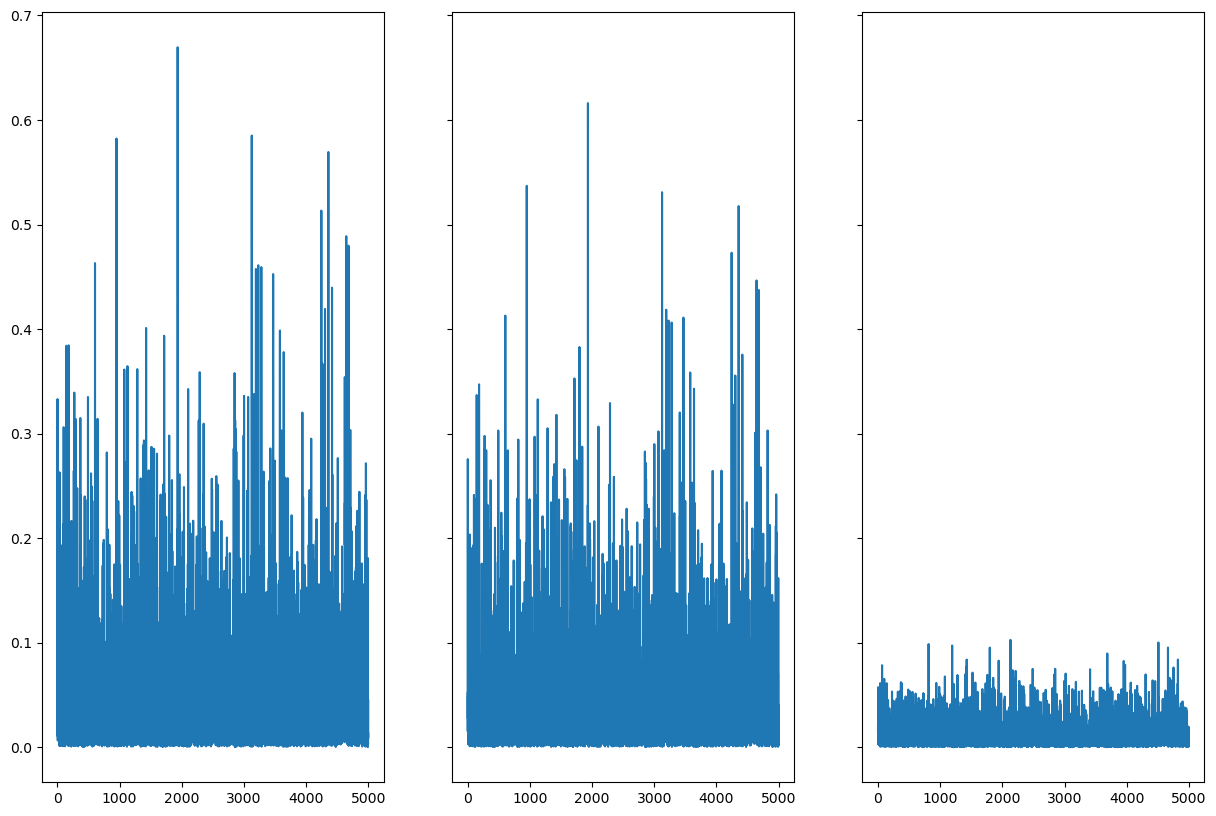

In [18]:
dif1 = np.linalg.norm(np.array(gp1).reshape(nsim,6) - np.array(solver).reshape(nsim,6), ord=2, axis=1)
dif2 = np.linalg.norm(np.array(gp2).reshape(nsim,6) - np.array(solver).reshape(nsim,6), ord=2, axis=1)
dif3 = np.linalg.norm(np.array(gp1).reshape(nsim,6) - np.array(gp2).reshape(nsim,6), ord=2, axis=1)

fig, axs = plt.subplots(1,3, figsize=(15, 10), sharey=True)

axs[0].plot(dif1)
axs[1].plot(dif2)
axs[2].plot(dif3)


In [19]:
data = np.load(f"./results/mcmc_da_pigp_mean_spatial6_nsol{100}_kl{4}_0.0001_0.npy")
stat = stat_ar(data, every=10000)[-1]

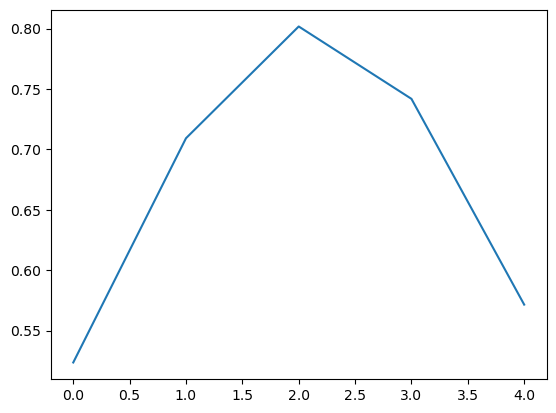

In [20]:
plt.plot(stat)

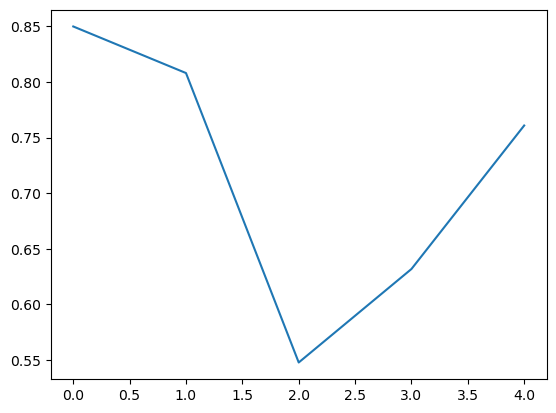

In [21]:
data = np.load(f"./results/mcmc_da_pigp_mean_spatial6_nsol{75}_kl{4}_0.0001_0.npy")
stat = stat_ar(data, every=10000)[-1]
plt.plot(stat)

FileNotFoundError: [Errno 2] No such file or directory: './results/mcmc_da_nn_hl2_nn100_s4000_batch25_kl4_0.0001_0.npy'

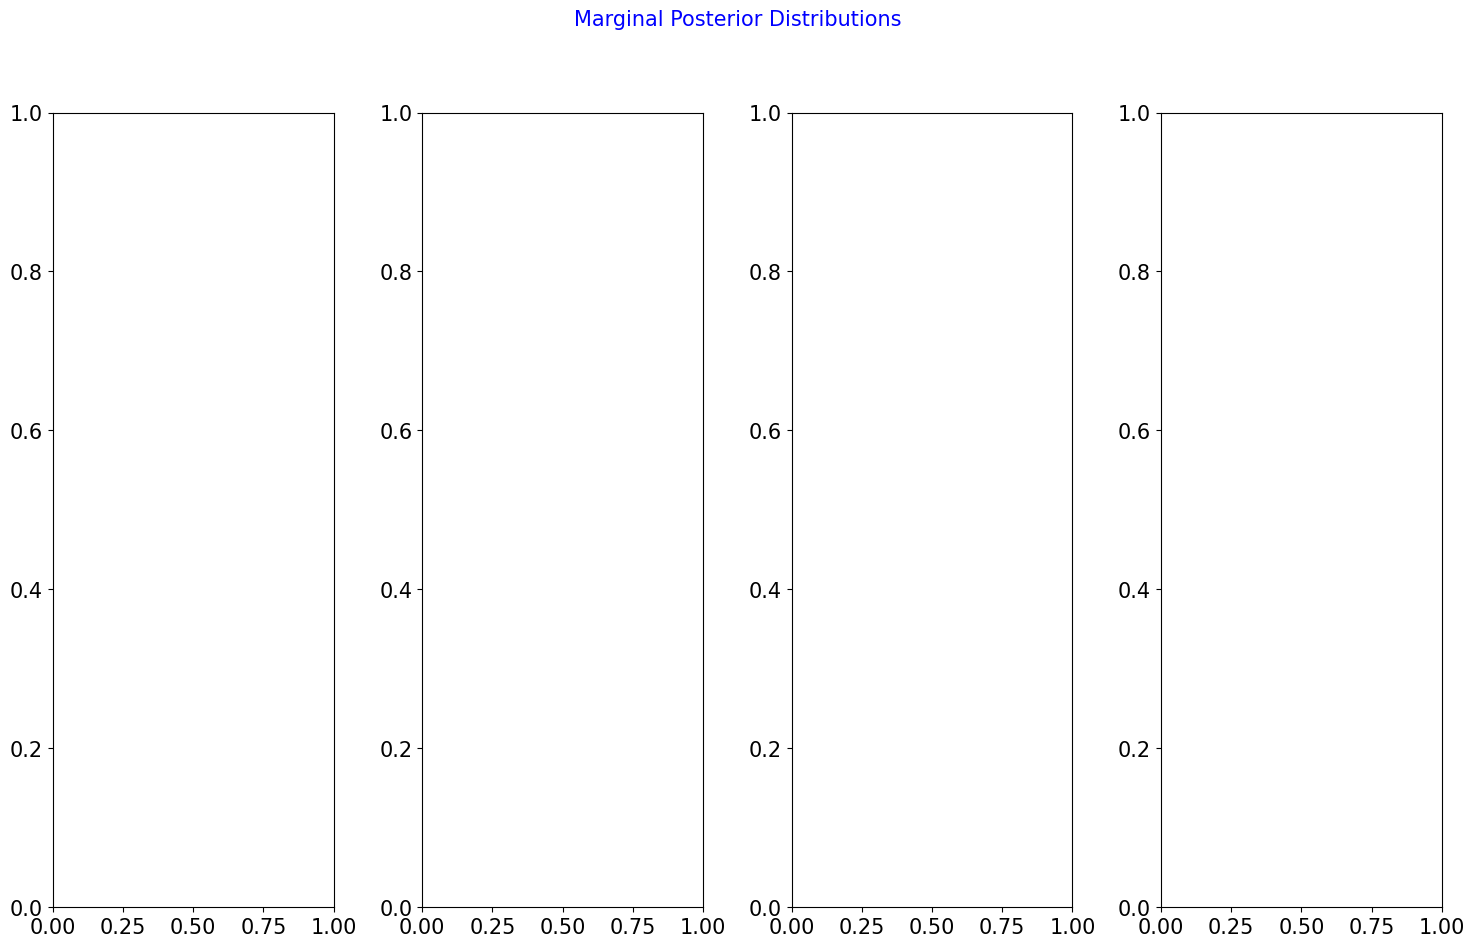

In [3]:
vr = 1e-4
theta_th = theta_thruth = np.array([0.098, 0.430, 0.206, 0.090, -0.153,
                              0.292, -0.125, 0.784, 0.927, -0.233,
                              0.762,-0.084, -0.492,0.328,0.521,
                              0.005,-0.482,0.123,-0.765,0.981])

nobs = 4000  # All N you want to plot
nn =[100]
kl = [4]
bins = 80
#100 160 200 250 400 500
batches = [25, 35, 50, 75]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            sample_nn = np.load(f'./results/NN_hl2_nn{100}_s{nobs}_batch{batch}_kl{k}_var{vr}_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"NN(batch={batch})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/FEM_kl{k}_var{vr}.npy')

                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"./results/images/elliptic_pd_kls_nn{nn}_var{vr}.pdf")


# For each kl, collect acceptance means across N
acceptance_mean_list = []

for kls in kl:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/mcmc_da_nn_hl2_nn{100}_s{nobs}_batch{batch}_kl{kls}_{vr}_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(12, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
fig.suptitle("NN 100 neurons and #DataTraining:4,000")
# Create boxplot
for i,batch in enumerate(batches):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax.set_ylabel("$\\alpha_{val}$")
    ax.set_title(f"Batch_size:{batch} ", color="blue")
    ax.grid(True)
    ax.set_xlabel("# KL terms")


#plt.savefig(f"./results/images/elliptic_da_ar_kls_nn{nn}_{vr}.pdf", bbox_inches='tight')
plt.tight_layout()

# axs.legend(frameon =False)
# plt.show()

# PIGP

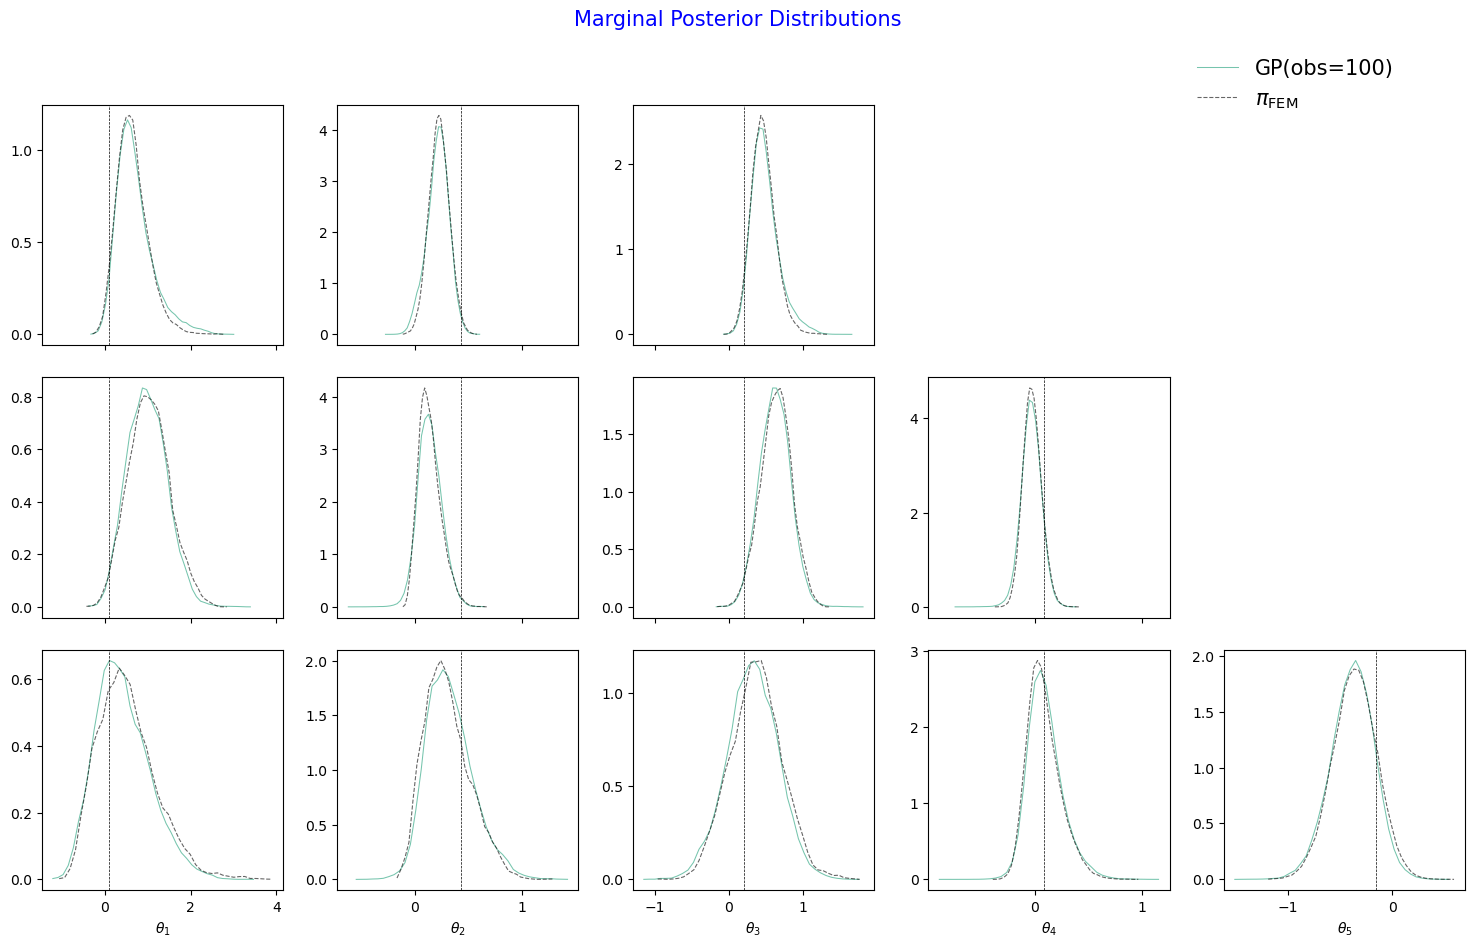

In [8]:
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])

#nn = [10, 25,50,75,100]
nn = [100]
kl = [3,4,5]
m = "marginal"
bins = 40
vr = 1e-4

colors = plt.cm.Dark2(np.linspace(0, 1, len(nn)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,neurons in enumerate(nn):
        try:
            sample_gp = np.load(f'./results/PIGP_{m}_spatial6_nsol{neurons}_kl{k}_var0.0001_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N=, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_gp[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"GP(obs={neurons})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/FEM_kl{k}_var{vr}.npy')
    
                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#plt.savefig(f"./results/images/elliptic_pd_kls_gp{nn}_var{vr}.pdf")


TypeError: 'Axes' object is not subscriptable

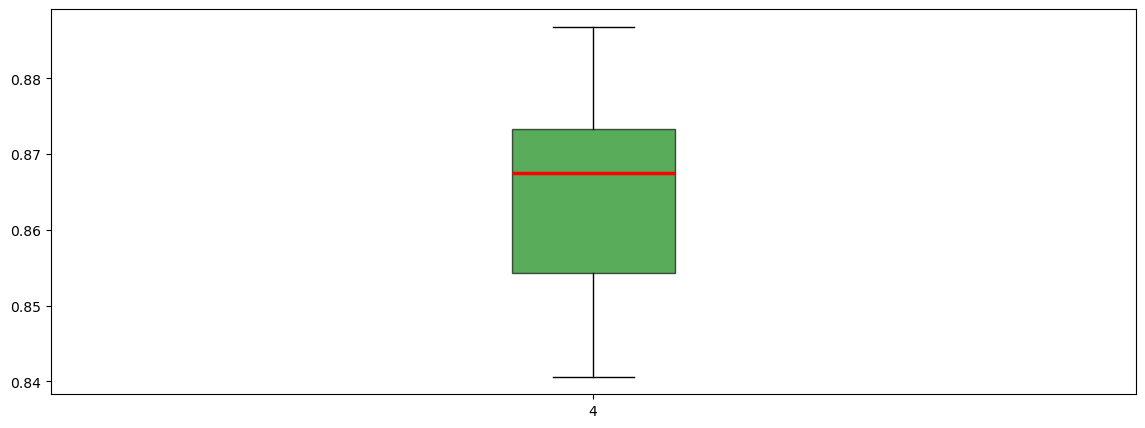

In [10]:
#nn = [10, 25,50,75,100]
nn = [100]
kl = [4]
# For each kl, collect acceptance means across N
acceptance_mean_list = []
m="mean"
for kls in kl:
    tmp = []
    for n in nn:
        data = np.load(f"./results/mcmc_da_pigp_{m}_spatial6_nsol{n}_kl{kls}_0.0001_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(nn),figsize=(14, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})

# Create boxplot
for i,n in enumerate(nn):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax[i].set_ylabel("$\\alpha_{val}$")
    ax[i].set_title(f"GP(obs={n})", color="blue")
    ax[i].grid(True)
    ax[i].set_xlabel("# KL terms")

plt.tight_layout()
plt.savefig(f"./results/images/elliptic_da_ar_kls_gp{nn}_{vr}.pdf", bbox_inches='tight')


In [107]:
grid = 50
parameter  = np.linspace(-1,1,grid)
batches = [ 250, 400, 500]
gpobs = [25,50,75]

# Initialize results array
results = np.zeros((grid, grid,grid, len(batches)))
results_gp = np.zeros((grid, grid,grid, len(batches)))

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-4),
                                            nparam=3,
                                            vert=50)

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(3), vert = 50, M=3)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        for z, par3 in enumerate(parameter):
            pr = np.array([par1, par2,par3])

            # Update the solver with new parameter values
            solver.theta = pr  # Update the parameter vector
            solver.uh = None  # Reset the FEM solution
            solver.solve()

            # Get FEM solution arrays
            y_FEM = solver.eval_at_points(obs_points).reshape(-1, 1)

            data = torch.tensor(np.hstack((obs_points, np.ones((obs_points.shape[0], pr.shape[0])) * pr))).float()

            # Loop over observation sizes N
            for l, (batch,gpn) in enumerate(zip(batches,gpobs)):

                model_path = f"./models/elliptic_hl2_nn100_s4000_batch{batch}_kl3.pth"
                gp_model_path = f"./models/elliptic_pigp__spatial6_nsol{gpn}_kl3.pt"

                elliptic = torch.load(model_path)
                elliptic.eval()

                gp_model = torch.load(gp_model_path)

                surg = elliptic.model(data).detach().cpu().numpy().reshape(-1, 1)

                pr = torch.tensor(pr).reshape(1, -1)
                mean = gp_model.prediction(pr,var=False)
                mean = mean.numpy()

                # Compute the maximum error between FEM and surrogate
                max_error = np.max(np.abs(y_FEM - surg))
                results[i, j, z, l] = max_error

                max_error_gp = np.max(np.abs(y_FEM - mean))
                results_gp[i, j, z, l] = max_error_gp


# Presentation

In [24]:
from elliptic_files.FEM_Solver import FEMSolver

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-2),
                                            nparam=2,
                                            vert=50)
x_obs = [0]+list(obs_points.flatten())+[1]
y_obs = [0]+list(sol_test.flatten())+[2]

theta_thruth = np.array([0.098, 0.430])

solver1 = FEMSolver(np.array([1, -0.430]),vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)


solver2 = FEMSolver(np.array([0.7, -0.430]),vert=50,M=theta_thruth.shape[0])
solution = solver2.solve()

sol_points2 = solver2.eval_at_points(obs_points)


solver3 = FEMSolver(np.array([0.5, 0.5]),vert=50,M=theta_thruth.shape[0])
solution = solver3.solve()

sol_points3 = solver3.eval_at_points(obs_points)

solver4 = FEMSolver(np.array([0.7, 0]),vert=50,M=theta_thruth.shape[0])
solution = solver4.solve()

sol_points4 = solver4.eval_at_points(obs_points)

solver5 = FEMSolver(np.array([0.7, 0.1]),vert=50,M=theta_thruth.shape[0])
solution = solver5.solve()

sol_points5 = solver5.eval_at_points(obs_points)

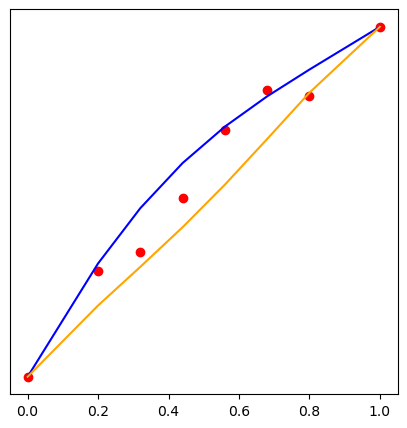

In [29]:
fig, axs = plt.subplots(1, figsize=(5, 5))

axs.scatter(x_obs,y_obs, label = "$y = u(x,\\theta^{\\dag})+ \\eta$ ", color ="red")
axs.plot(x_obs,[0]+list(sol_points1.flatten())+[2], label = "$u(x,\\theta = (1,-0.4))$",color ="blue")
#axs.plot(x_obs,[0]+list(sol_points2.flatten())+[2], label = "u(x,(1,0.7))", color ="green")
axs.plot(x_obs,[0]+list(sol_points3.flatten())+[2], label = "$u(x,\\theta = (0.5,0.5))$", color = "orange")
# axs.plot(x_obs,[0]+list(sol_points4.flatten())+[2], label = "$u(x,\\theta = (0.5,0.5))$", color = "purple")
# axs.plot(x_obs,[0]+list(sol_points5.flatten())+[2], label = "$u(x,\\theta = (0.5,0.5))$", color = "brown")


#axs.legend(frameon =False, loc='upper left')

axs.set_yticks([])           # Removes y-ticks
axs.set_ylabel("")           # Removes y-axis label

plt.savefig(f"elliptic_ex4.pdf")


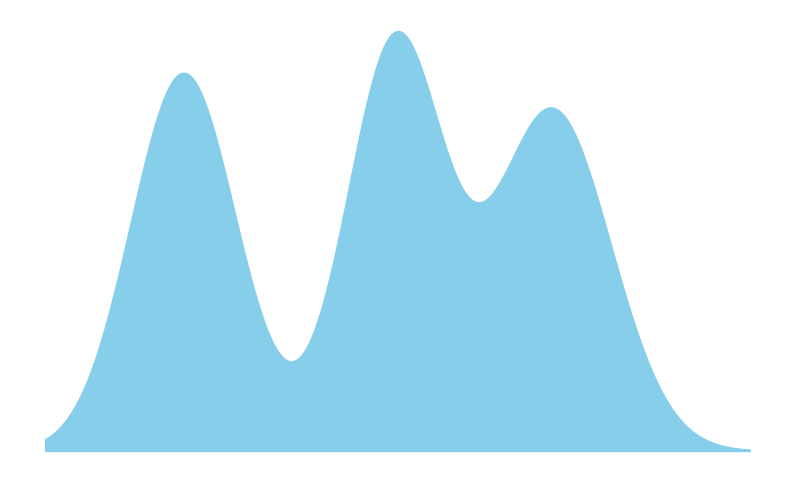

In [11]:
# Use matplotlib directly to plot a smooth KDE without histogram, axes, or grid

from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(42)

# Generate data with three modes (a mixture of three normal distributions)
data1 = np.random.normal(loc=-2, scale=0.5, size=1000)
data2 = np.random.normal(loc=2, scale=0.3, size=1000)
data3 = np.random.normal(loc=5, scale=0.7, size=1000)

# Combine the data
data = np.concatenate([data1, data2, data3])

# Estimate the KDE of the data
kde = gaussian_kde(data, bw_method=0.3)

# Create a range of x values for plotting the KDE
x_vals = np.linspace(min(data) - 1, max(data) + 1, 1000)
y_vals = kde(x_vals)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.fill_between(x_vals, y_vals, color='skyblue')

# Remove axes and grid
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
plt.box(False)
sns.despine(left=True, bottom=True)

plt.savefig(f"pd.pdf")

plt.show()


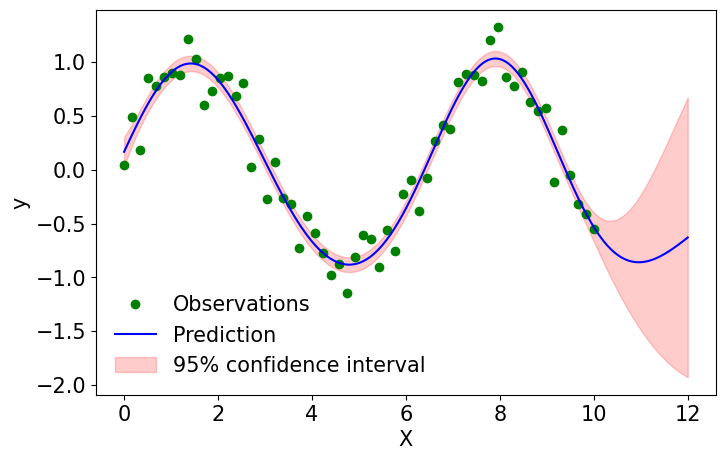

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 1. Generate sample data
X = np.atleast_2d(np.linspace(0, 10, 60)).T
y = np.sin(X).ravel()

# Add noise to targets
y += 0.2 * np.random.normal(size=y.shape)

# 2. Define the kernel: constant * RBF (squared exponential)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# 3. Create GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1**2)

# 4. Fit to data
gp.fit(X, y)

# 5. Predict on new data
X_pred = np.atleast_2d(np.linspace(0, 12, 1000)).T
y_pred, sigma = gp.predict(X_pred, return_std=True)

# 6. Plot results
plt.figure(figsize=(8,5))
plt.plot(X, y, 'go', label='Observations')
plt.plot(X_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(X_pred.ravel(),
                 y_pred - 1.96 * sigma,
                 y_pred + 1.96 * sigma,
                 alpha=0.2, label='95% confidence interval', color="red")
plt.xlabel('X')
plt.ylabel('y')
plt.legend(frameon=False)
#plt.title('Gaussian Process Regression')
plt.savefig(f"GP.pdf")

plt.show()


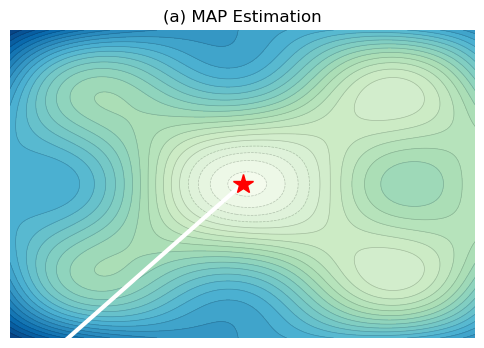

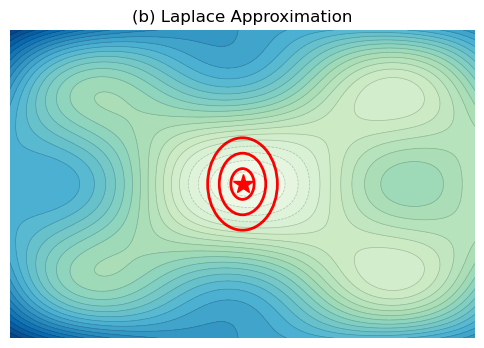

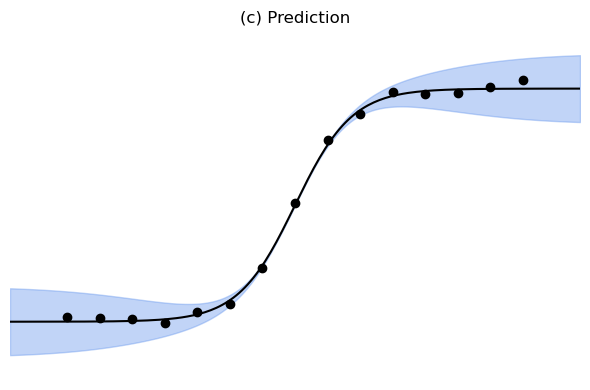

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Setup figure
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# Simulate a 2D loss surface
x = np.linspace(-2, 1, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (X**2 + 2*Y**2) + np.sin(3*X) * np.cos(3*Y)

# ---- (a) MAP Estimation ----
ax = axes
ax.set_title("(a) MAP Estimation")
ax.contourf(X, Y, Z, levels=30, cmap='GnBu')
ax.contour(X, Y, Z, levels=30, colors='black', alpha=0.2, linewidths=0.5)

# Simulated optimization path
path_x = np.linspace(-2, -.5, 10)
path_y = np.linspace(-2, 0, 10)
ax.plot(path_x, path_y, 'w-', lw=3)
ax.plot(-.5, 0, 'y*', markersize=15, color = "red")  # MAP estimate
ax.set_xlim(-2, 1)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.savefig("MAP.pdf")

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# ---- (b) Laplace Approximation ----
ax = axes
ax.set_title("(b) Laplace Approximation")
ax.contourf(X, Y, Z, levels=30, cmap='GnBu')
ax.contour(X, Y, Z, levels=30, colors='black', alpha=0.2, linewidths=0.5)

ax.plot(-.5, 0, 'y*', markersize=15,color = "red")

# Ellipses around MAP for covariance (Laplace approx)
for i in range(1, 4):
    ellipse = Ellipse(xy=(-.5, 0), width=0.15*i, height=0.3*i,
                      edgecolor='red', facecolor='none', lw=2)
    ax.add_patch(ellipse)

ax.set_xlim(-2, 1)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.savefig("Laplace.pdf")

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# ---- (c) Prediction ----
ax = axes
ax.set_title("(c) Prediction")
x_line = np.linspace(-5, 5, 200)
true_function = np.tanh(x_line)
uncertainty = 0.3 * (1 - np.exp(-x_line**2 / 8))

ax.plot(x_line, true_function, 'k', label='Mean prediction')
ax.fill_between(x_line, true_function - uncertainty, true_function + uncertainty,
                color='cornflowerblue', alpha=0.4, label='Uncertainty')

# Sample training points
x_train = np.linspace(-4, 4, 15)
y_train = np.tanh(x_train) + np.random.normal(0, 0.05, size=x_train.shape)
ax.plot(x_train, y_train, 'ko', label='Data')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.tight_layout()
plt.show()


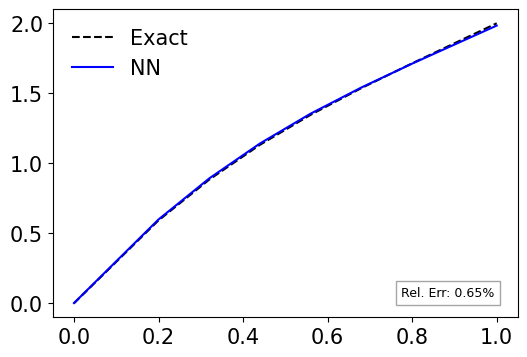

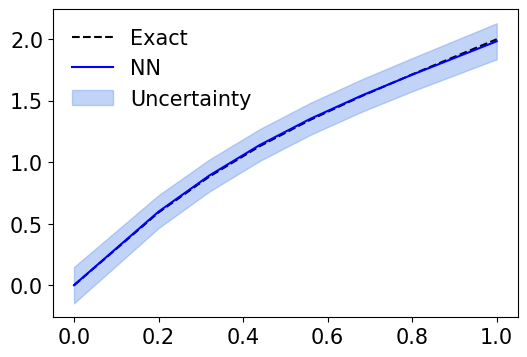

In [165]:
from elliptic_files.FEM_Solver import FEMSolver

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-2),
                                            nparam=2,
                                            vert=50)
x_obs = [0]+list(obs_points.flatten())+[1]
y_obs = [0]+list(sol_test.flatten())+[2]

observation_locations = torch.tensor(x_obs).reshape(-1,1)

theta_thruth = np.array([0.098, 0.430])

#fig.suptitle("In Distribution", color = "g")

thet = np.array([0.99275248, -0.2209955])
solver1 = FEMSolver(thet,vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)

path_dgala_model = "./models/elliptic_dgala_hl2_nn20_s100_kl2.pth"

llp = torch.load(path_dgala_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.sigma_noise = 1.
theta = torch.tensor(thet).reshape(1,-1)
data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
surg_mu, surg_sigma = llp(data)

surg_mu = surg_mu.view(-1, 1)
surg_sigma = surg_sigma[:, :, 0].view(-1, 1).sqrt()

# ---- (c) Prediction ----
#axes[0].set_title(f"$\\theta$ = ({thet[0]:0.1f},{thet[1]:0.1f})", color="g")
fig, axes = plt.subplots(1, 1, figsize=(6,4),sharex=True)

axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, 'k', label='NN',color = "blue")


# --- Relative Error Plot ---
rel_error_l2 = np.linalg.norm((surg_mu.numpy() - np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)) / np.linalg.norm(np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)))
axes.text(0.95, 0.1, f"Rel. Err: {rel_error_l2:.2%}", 
                transform=axes.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

axes.legend(frameon = False)
plt.savefig("dgala1a.pdf", bbox_inches='tight')

    # ---- (c) Prediction ----
#axes[1].set_title(f"$\\theta$ = ({thet[0]:0.1f},{thet[1]:0.1f})", color="g")
fig, axes = plt.subplots(1, 1, figsize=(6,4),sharex=True)

axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, 'k', label='NN',color = "blue")
axes.fill_between(observation_locations.flatten(), surg_mu.flatten() - surg_sigma.flatten(), surg_mu.flatten() + surg_sigma.flatten(),
                color='cornflowerblue', alpha=0.4, label='Uncertainty')


axes.legend(frameon = False)

plt.savefig("dgala1b.pdf", bbox_inches='tight')



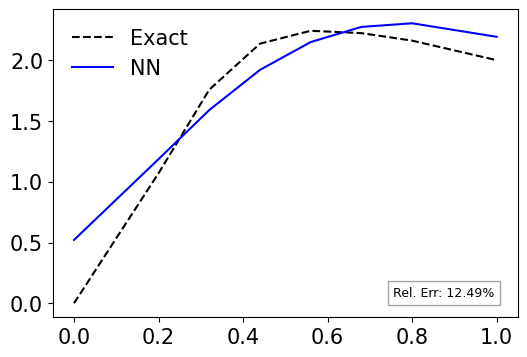

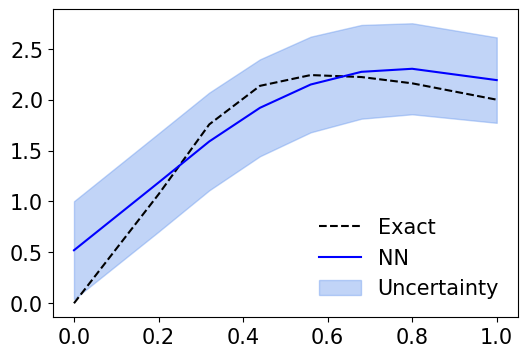

In [166]:
#fig.suptitle("Out of Distribution", color = "r")

thet = np.array([-2, -2])
solver1 = FEMSolver(thet,vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)

path_dgala_model = "./models/elliptic_dgala_hl2_nn20_s100_kl2.pth"

llp = torch.load(path_dgala_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.sigma_noise = 1.
theta = torch.tensor(thet).reshape(1,-1)
data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
surg_mu, surg_sigma = llp(data)

surg_mu = surg_mu.view(-1, 1)
surg_sigma = surg_sigma[:, :, 0].view(-1, 1).sqrt()


# ---- (c) Prediction ----
#axes[0].set_title(f"$\\theta$ = ({thet[0]:0.1f},{thet[1]:0.1f})", color="g")
fig, axes = plt.subplots(1, 1, figsize=(6,4),sharex=True)

axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, 'k', label='NN',color = "blue")


# --- Relative Error Plot ---
rel_error_l2 = np.linalg.norm((surg_mu.numpy() - np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)) / np.linalg.norm(np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)))
axes.text(0.95, 0.1, f"Rel. Err: {rel_error_l2:.2%}", 
                transform=axes.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
axes.legend(frameon = False)

plt.savefig("dgala2a.pdf", bbox_inches='tight')

    # ---- (c) Prediction ----
#axes[1].set_title(f"$\\theta$ = ({thet[0]:0.1f},{thet[1]:0.1f})", color="g")
fig, axes = plt.subplots(1, 1, figsize=(6,4),sharex=True)

axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, 'k', label='NN',color = "blue")
axes.fill_between(observation_locations.flatten(), surg_mu.flatten() - surg_sigma.flatten(), surg_mu.flatten() + surg_sigma.flatten(),
                color='cornflowerblue', alpha=0.4, label='Uncertainty')


axes.legend(frameon = False)
plt.savefig("dgala2b.pdf", bbox_inches='tight')


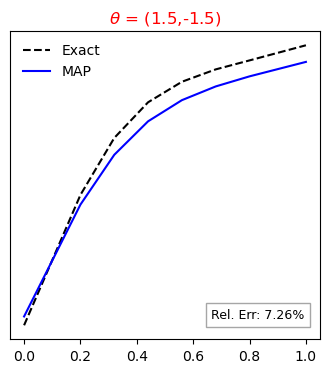

In [ ]:
from elliptic_files.FEM_Solver import FEMSolver

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-2),
                                            nparam=2,
                                            vert=50)
x_obs = [0]+list(obs_points.flatten())+[1]
y_obs = [0]+list(sol_test.flatten())+[2]

observation_locations = torch.tensor(x_obs).reshape(-1,1)

theta_thruth = np.array([1.5, -1.5])

solver1 = FEMSolver(theta_thruth,vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)

path_dgala_model = "./models/elliptic_dgala_hl2_nn20_s100_kl2.pth"

llp = torch.load(path_dgala_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.sigma_noise = 1.
theta = torch.tensor(theta_thruth).reshape(1,-1)
data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
surg_mu, surg_sigma = llp(data)

surg_mu = surg_mu.view(-1, 1)
surg_sigma = surg_sigma[:, :, 0].view(-1, 1).sqrt()

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

# ---- (c) Prediction ----
axes.set_title(f"$\\theta$ = ({theta_thruth[0]:0.1f},{theta_thruth[1]:0.1f})", color="red")
axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, '-', label='MAP',color = "blue")

    # --- Relative Error Plot ---
rel_error_l2 = np.linalg.norm((surg_mu.numpy() - np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)) / np.linalg.norm(np.array([0]+list(sol_points1.flatten())+[2]).reshape(-1,1)))
axes.text(0.95, 0.1, f"Rel. Err: {rel_error_l2:.2%}", 
                transform=axes.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))


axes.set_yticks([])           # Removes y-ticks
axes.set_ylabel("")  
axes.legend(frameon = False)
plt.savefig("dgala2.pdf")

In [30]:
samples_param(100,2)

array([[-0.47849285,  0.7775588 ],
       [-0.94599095, -0.32889673],
       [ 0.84865827,  0.00117257],
       [ 0.22554818, -0.91435519],
       [ 0.08650125, -0.90508749],
       [-0.91447564,  0.6393561 ],
       [ 0.99275248, -0.2209955 ],
       [-0.71292978,  0.41615114],
       [ 0.09094574, -0.50229902],
       [ 0.83499725, -0.94714567],
       [-0.2268592 , -0.24808884],
       [-0.95956322,  0.18707057],
       [ 0.36287607, -0.85771836],
       [-0.40170608, -0.50884461],
       [ 0.16636359, -0.49522933],
       [ 0.63801297, -0.44062063],
       [ 0.5428511 , -0.13440745],
       [-0.47824317, -0.88421434],
       [-0.5790227 , -0.02810354],
       [-0.84934086, -0.85461123],
       [-0.67209433,  0.01058461],
       [-0.50131017,  0.18844589],
       [ 0.37035831, -0.98933848],
       [-0.6792314 , -0.89676373],
       [-0.55285303, -0.91775658],
       [-0.08998023, -0.43605905],
       [ 0.61024348, -0.23329436],
       [-0.50669319, -0.08501174],
       [ 0.64185309,

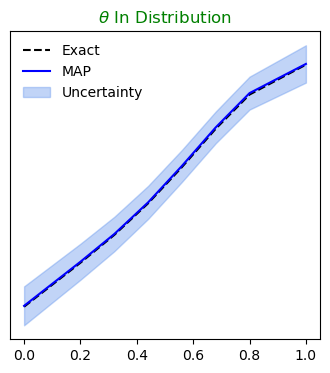

In [31]:
from elliptic_files.FEM_Solver import FEMSolver

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-2),
                                            nparam=2,
                                            vert=50)
x_obs = [0]+list(obs_points.flatten())+[1]
y_obs = [0]+list(sol_test.flatten())+[2]

observation_locations = torch.tensor(x_obs).reshape(-1,1)

theta_thruth = np.array([-0.47849285,  0.7775588 ])

solver1 = FEMSolver(theta_thruth,vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)

path_dgala_model = "./models/elliptic_dgala_hl2_nn20_s100_kl2.pth"

llp = torch.load(path_dgala_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.sigma_noise = 1.
theta = torch.tensor(theta_thruth).reshape(1,-1)
data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
surg_mu, surg_sigma = llp(data)

surg_mu = surg_mu.view(-1, 1)
surg_sigma = surg_sigma[:, :, 0].view(-1, 1).sqrt()

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

# ---- (c) Prediction ----
axes.set_title("$\\theta$ In Distribution", color="g")

axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, 'k', label='MAP',color = "blue")
axes.fill_between(observation_locations.flatten(), surg_mu.flatten() - surg_sigma.flatten(), surg_mu.flatten() + surg_sigma.flatten(),
                color='cornflowerblue', alpha=0.4, label='Uncertainty')

axes.set_yticks([])           # Removes y-ticks
axes.set_ylabel("")  
axes.legend(frameon = False)
plt.savefig("indis.pdf")


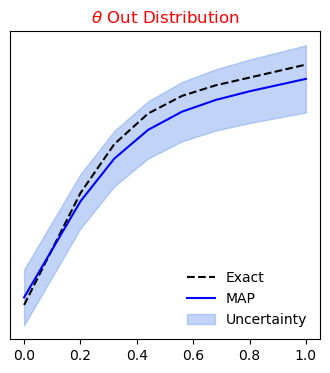

In [88]:
from elliptic_files.FEM_Solver import FEMSolver

obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-2),
                                            nparam=2,
                                            vert=50)
x_obs = [0]+list(obs_points.flatten())+[1]
y_obs = [0]+list(sol_test.flatten())+[2]

observation_locations = torch.tensor(x_obs).reshape(-1,1)

theta_thruth = np.array([0.098, 0.430])

solver1 = FEMSolver(np.array([1.5, -1.5]),vert=50,M=theta_thruth.shape[0])
solution = solver1.solve()

sol_points1 = solver1.eval_at_points(obs_points)

path_dgala_model = "./models/elliptic_dgala_hl2_nn20_s100_kl2.pth"

llp = torch.load(path_dgala_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.sigma_noise = 1.
theta = torch.tensor(np.array([1.5, -1.5])).reshape(1,-1)
data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
surg_mu, surg_sigma = llp(data)

surg_mu = surg_mu.view(-1, 1)
surg_sigma = surg_sigma[:, :, 0].view(-1, 1).sqrt()

fig, axes = plt.subplots(1, 1, figsize=(4, 4))

# ---- (c) Prediction ----
axes.set_title("$\\theta$ Out Distribution", color="red")
axes.plot(observation_locations, [0]+list(sol_points1.flatten())+[2], '--', label='Exact',color = "black")
axes.plot(observation_locations, surg_mu, '-', label='MAP',color = "blue")
axes.fill_between(observation_locations.flatten(), surg_mu.flatten() - surg_sigma.flatten(), surg_mu.flatten() + surg_sigma.flatten(),
                color='cornflowerblue', alpha=0.4, label='Uncertainty')

axes.set_yticks([])           # Removes y-ticks
axes.set_ylabel("")  
axes.legend(frameon = False)
plt.savefig("outdis.pdf")


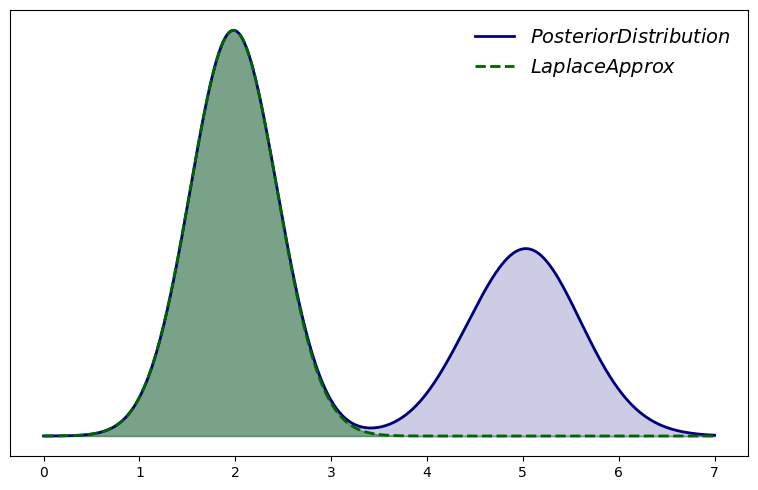

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gaussian_kde

# Simulate a bimodal posterior distribution
np.random.seed(0)
posterior_samples = np.concatenate([
    np.random.normal(2, 0.3, 1000),
    np.random.normal(5, 0.5, 600)
])

# Kernel density estimation (KDE) of posterior
kde = gaussian_kde(posterior_samples)
w = np.linspace(0, 7, 1000)
posterior_density = kde(w)

# Find MAP estimate (mode of the posterior)
w_map = w[np.argmax(posterior_density)]

# Estimate local curvature (second derivative of log density) at MAP
# Numerical second derivative of log KDE at MAP
eps = 1e-3
log_kde = np.log(kde(w_map + eps)), np.log(kde(w_map)), np.log(kde(w_map - eps))
second_derivative = (log_kde[0] - 2 * log_kde[1] + log_kde[2]) / (eps**2)
laplace_std = np.sqrt(-1 / second_derivative)  # std from curvature

# Laplace approximation: Gaussian centered at MAP
laplace = norm.pdf(w, loc=w_map, scale=laplace_std)

# Scale the Laplace peak to match the posterior at MAP
laplace *= max(posterior_density) / max(laplace)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(w, posterior_density, label=r'$Posterior Distribution$', color='navy', linewidth=2)
plt.fill_between(w, posterior_density, alpha=0.2, color='navy')

plt.plot(w, laplace, label=r'$Laplace Approx$', color='darkgreen', linestyle='--', linewidth=2)
plt.fill_between(w, laplace, alpha=0.4, color='darkgreen')

#plt.xlabel(r'$w$', fontsize=14)
#plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=14, frameon = False)
plt.grid(False)
plt.tight_layout()

plt.yticks([])           # Removes y-ticks
plt.ylabel("")  
plt.savefig("laplace_fig.pdf")

In [26]:
def generate_noisy_obs(obs, nparam=2,vert=1000, mean=0, std=np.sqrt(1e-4)):
    """
    Generates noisy observations for given parameters and observation points.
    """
    theta_thruth = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292, -0.125, 0.784, 0.927, -0.233])
    theta_t = theta_thruth[:nparam]
    print(theta_t)
    # Solve the FEM problem using the given theta values and roots
    solver = FEMSolver(theta_t,vert=vert,M=theta_t.shape[0])
    solution = solver.solve()

    # Extract observation points and the solution points
    obs_points, sol_points = solver.solution_array()

    # Choose indices for the observation points, including start and end
    obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)

    # Select the observation and solution points based on the indices
    sol_points = solver.eval_at_points(obs_points)

    # Generate noise and add it to the solution points
    noise_sol_points = add_noise(sol_points, mean, std)

    # Ensure proper reshaping of observation and solution points
    obs_points = obs_points.reshape(-1, 1)
    sol_test = noise_sol_points.reshape(-1, 1)

    return obs_points, sol_test

def add_noise(solution, mean, std, seed = 0):
    """
    Adds Gaussian noise to the solution.
    """
    # rng = np.random.default_rng(seed)
    # noise = rng.normal(mean, std, solution.shape)
    np.random.seed(seed)
    noise = np.random.normal(mean, std, solution.shape)
    return solution + noise


In [18]:
#theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292, -0.125, 0.784, 0.927, -0.233])
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
fem_solver = FEMSolver(theta_th, M = 6, vert=50)
fem_solver.solve()

#x,y = fem_solver.solution_array()


Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, gll_warped, unset, False, float64, []), (1,)), 0), Basix element (P, interval, 1, gll_warped, unset, False, float64, [])), 4)

In [19]:
from elliptic_files.train_elliptic import dGDataset, generate_test_data

data_parameters = samples_param(300, nparam=6,seed=65647437836358831880808032086803839626)

param_train, param_test = data_parameters[:150,:],  data_parameters[150:,:]

dataset = dGDataset(size = 150, param=param_train)

x_val,param_val, sol_val = generate_test_data(150,param =param_test, vert=30,
                                                nparam=6,M = 6)

In [22]:
model_specific = f"_s{150}_kl{6}"
path_nn_model = f"./models/elliptic"+model_specific+".pth"
path_dgala_model = f"../models/elliptic_dgala"+model_specific+".pth"

nn_surrogate_model = torch.load(path_nn_model)


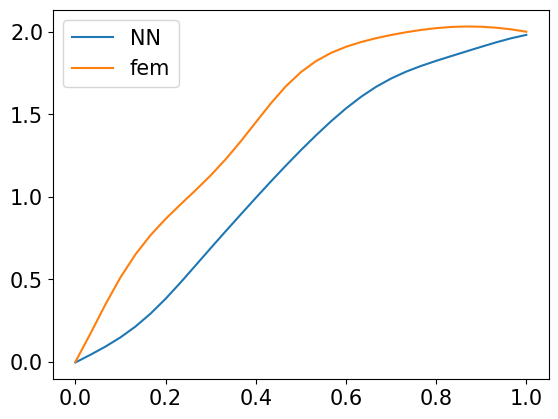

In [31]:
i = 100
dt = torch.tensor(0.5)
theta = torch.empty((6), device=device).uniform_(-1, 1)
theta_p = theta*torch.sqrt(1-dt**2) + torch.normal(mean=torch.zeros_like(theta), std=dt) 
#theta = torch.tensor(param_val[i,:]).reshape(-1)
data_test = torch.cat([torch.tensor(x_val), theta_p.repeat(x_val.shape[0], 1)], dim=1).float()

surg_mu = nn_surrogate_model.u(data_test)

plt.plot(x_val.flatten(),surg_mu.detach().numpy(),label = "NN")
plt.plot(x_val.flatten(),sol_val[i,:].flatten(),label = "fem")
plt.legend()

In [ ]:
vr = 1e-4
theta_th=np.array([0.098, 0.430])
N = [150,250,500,750,1000,1500,2500]
bins = 50
kl = 2

fig, axs = plt.subplots(len(N), 2, figsize=(12, 7), sharex="col")
fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 15})

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/NNdg2_s{nobs}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./results/dgaladg2_s{nobs}_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, prop={'size': 9})
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)


axs[-1,0].set_xlim((-0.5,0.5)),axs[-1,1].set_xlim((0.1,0.7))
axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

plt.savefig(f"./results/images/elliptic_pd_kl{kl}_{vr}.jpg") 

In [ ]:

def get_deepgalerkin_config():
    config = ConfigDict()

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "Elliptic-training"
    wandb.name = "MDNN"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"elliptic":1, "ubcl":1, "ubcr":1}

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3
    config.model.hidden_dim = 20
    config.model.num_layers = 2
    config.model.out_dim = 1
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    #config.reparam = ConfigDict({"type":"weight_fact","mean":1.0,"stddev":0.1})

     # Periodic embeddings
    #config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    #config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":256,"exclude_last_n":100})

    # Config KL parameters
    config.nparameters = 2

    # Training settings
    config.seed = 42
    config.learning_rate = 0.001
    config.decay_rate = 0.95
    # config.alpha = 0.9  # For updating loss weights
    config.epochs = 5000
    config.start_scheduler = 0.5
    # config.weights_update = 250
    config.scheduler_step = 50

    config.samples = 5000
    config.batch_size = 150

    
    return config

In [ ]:
N = [150,250,500,750,1000,1500,2500]

# Loop through each sample size
# for samples in N:
#     print(f"Running training with {samples} samples...")
#     config = get_deepgalerkin_config()
#     config.wandb.name = f"MDNN_s{samples}"
#     config.samples = samples  # Update the samples in the config
#     pinn_nvs = train_elliptic(config, device=device)
#     print(f"Completed training with {samples} samples.")

# NN vs FEM

In [4]:
grid = 75
vert = 50

results, X, Y = compute_max_error(N,vert=vert, grid=grid)

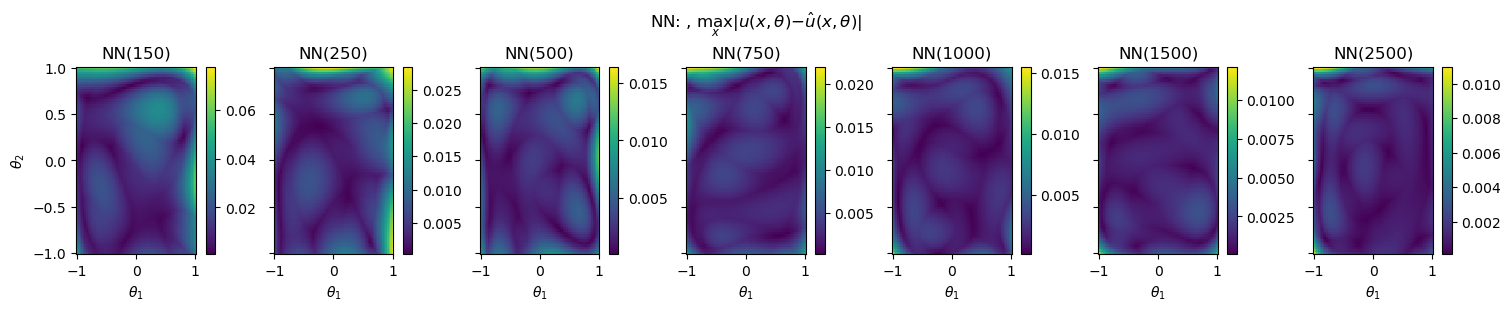

[0.01611701 0.00579275 0.00309188 0.00332786 0.00206926 0.00161969
 0.00134118]


In [5]:
plot_max_errors(N, results, X, Y, "")

print(results.mean(axis=(0,1)))

# Inverse Problem

In [13]:
# Define the model using a coarse FEM solver
def fem_surrogate(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def dgala_surrogate(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def nn_surrogate(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate.model(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

# Noisy Observations

In [9]:
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
obs_points, obs_sol = generate_noisy_obs(6,std=st)
hvert = 50

# MCMC

In [ ]:
config = get_deepgalerkin_config()

obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32), torch.tensor(obs_sol, dtype=torch.float32)
st = torch.sqrt(torch.tensor(vr,dtype=torch.float32)).to(device)

# # # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(fem_surrogate, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# surrogate_fem_solver = FEMSolver(theta=np.zeros(2), vert=hvert)

# # Run the MCMC inference
# mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# # Get the results (posterior samples)
# samples = mcmc_sampler.get_samples()
# samples = samples["theta"].numpy()

# np.save(f'./results/FEM_pyro_h{hvert}_var{vr}.npy', samples)

# del kernel, mcmc_sampler, samples

for nobs in N:
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()
    config.samples = nobs

#     kernel = mcmc.RandomWalkKernel(nn_surrogate, target_accept_prob=0.234)

#     mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(nn_surrogate_model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./results/MDNN_s{nobs}_noise{vr}.npy', samples)
#     del kernel, mcmc_sampler, samples

    #### Deep GaLA

    data_parameters = samples_param(config.samples*2, nparam=config.nparameters)
    
    param_train, param_test = data_parameters[:config.samples,:],  data_parameters[config.samples:,:]

    data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


    data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
                "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
                "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    llp = dgala(nn_surrogate_model)

    llp.fit(data_trainig)

    llp.optimize_marginal_likelihood()

    kernel = mcmc.RandomWalkKernel(dgala_surrogate, target_accept_prob=0.234)

    mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    print("Initializing MCMC")
    mcmc_sampler.run(llp,obs_sol,obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./results/dGaLA_s{nobs}_noise{vr}.npy', samples)
    del kernel, mcmc_sampler, samples

Iteration 100, Error: 0.00977, neg_marglik: 37.82544
Iteration 200, Error: 0.00882, neg_marglik: -389.97574
Iteration 300, Error: 0.00647, neg_marglik: -764.51276
Maximum iterations (300)reached, sigma : 0.05356171727180481, prior: 11.944536209106445.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [22:48, 734.33it/s, step size=1.50e-01, acc. prob=0.227]


Iteration 100, Error: 0.00975, neg_marglik: 18.97585
Iteration 200, Error: 0.00874, neg_marglik: -709.89136
Iteration 300, Error: 0.00656, neg_marglik: -1392.00598
Maximum iterations (300)reached, sigma : 0.05187401920557022, prior: 11.309439659118652.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:07, 792.60it/s, step size=1.26e-01, acc. prob=0.230]


Iteration 100, Error: 0.00972, neg_marglik: -26.87213
Iteration 200, Error: 0.00870, neg_marglik: -1508.62842
Iteration 300, Error: 0.00674, neg_marglik: -2962.38257
Maximum iterations (300)reached, sigma : 0.05070731043815613, prior: 11.018314361572266.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:19, 785.69it/s, step size=1.22e-01, acc. prob=0.237]


Iteration 100, Error: 0.00964, neg_marglik: -79.19411
Iteration 200, Error: 0.00839, neg_marglik: -2307.06396
Iteration 300, Error: 0.00628, neg_marglik: -4486.03369
Maximum iterations (300)reached, sigma : 0.05080720782279968, prior: 9.730432510375977.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:40, 773.03it/s, step size=1.20e-01, acc. prob=0.238]


Iteration 100, Error: 0.00966, neg_marglik: -128.19849
Iteration 200, Error: 0.00850, neg_marglik: -3108.55615
Iteration 300, Error: 0.00648, neg_marglik: -6054.71533
Maximum iterations (300)reached, sigma : 0.05054648593068123, prior: 10.142011642456055.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:41, 772.35it/s, step size=1.18e-01, acc. prob=0.238]


Iteration 100, Error: 0.00968, neg_marglik: -227.38416
Iteration 200, Error: 0.00858, neg_marglik: -4708.65234
Iteration 300, Error: 0.00661, neg_marglik: -9160.50977
Maximum iterations (300)reached, sigma : 0.05043128877878189, prior: 10.428465843200684.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:41, 772.41it/s, step size=1.16e-01, acc. prob=0.241]


Iteration 100, Error: 0.00968, neg_marglik: -437.55191
Iteration 200, Error: 0.00858, neg_marglik: -7916.80664
Iteration 300, Error: 0.00662, neg_marglik: -15352.75684
Maximum iterations (300)reached, sigma : 0.05042032152414322, prior: 10.449127197265625.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:39, 773.10it/s, step size=1.16e-01, acc. prob=0.239]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

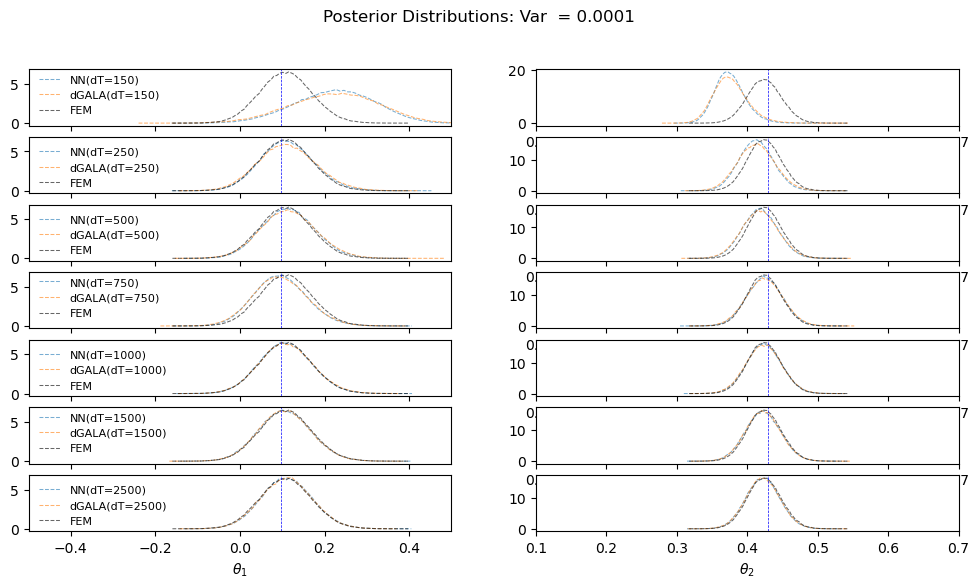

In [17]:
bins =80
vr = 1e-4
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/MDNN_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./results/dGaLA_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_pyro_h{hvert}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

# Same Experiment var=1e-5

In [3]:
vr = 1e-5
st = torch.sqrt(torch.tensor(vr))
obs_points, obs_sol = generate_noisy_obs(6,std=st)
hvert = 50

In [21]:
config = get_deepgalerkin_config()

obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32), torch.tensor(obs_sol, dtype=torch.float32)
st = torch.sqrt(torch.tensor(vr,dtype=torch.float32)).to(device)

# # # Define the MCMC kernel (using Random Walk Metropolis)
kernel = mcmc.RandomWalkKernel(fem_surrogate, target_accept_prob=0.234)

# Create an MCMC object with the kernel
mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

surrogate_fem_solver = FEMSolver(theta=np.zeros(2), vert=hvert)

# Run the MCMC inference
mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./results/FEM_pyro_h{hvert}_var{vr}.npy', samples)

del kernel, mcmc_sampler, samples

for nobs in N:
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()
    config.samples = nobs

    kernel = mcmc.RandomWalkKernel(nn_surrogate, target_accept_prob=0.234)

    mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    mcmc_sampler.run(nn_surrogate_model,obs_sol,obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./results/MDNN_s{nobs}_noise{vr}.npy', samples)
    del kernel, mcmc_sampler, samples

    #### Deep GaLA

    # data_parameters = samples_param(config.samples*2, nparam=config.nparameters)
    
    # param_train, param_test = data_parameters[:config.samples,:],  data_parameters[config.samples:,:]

    # data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    # data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


    # data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
    #             "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
    #             "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    # llp = dgala(nn_surrogate_model)

    # llp.fit(data_trainig)

    # llp.optimize_marginal_likelihood()

    # kernel = mcmc.RandomWalkKernel(dgala_surrogate, target_accept_prob=0.234)

    # mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    # print("Initializing MCMC")
    # mcmc_sampler.run(llp,obs_sol,obs_points,st)

    # # Get the results (posterior samples)
    # samples = mcmc_sampler.get_samples()
    # samples = samples["theta"].numpy()

    # np.save(f'./results/dGaLA_s{nobs}_noise{vr}.npy', samples)
    # del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [08:07, 2061.83it/s, step size=1.58e-02, acc. prob=0.164]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

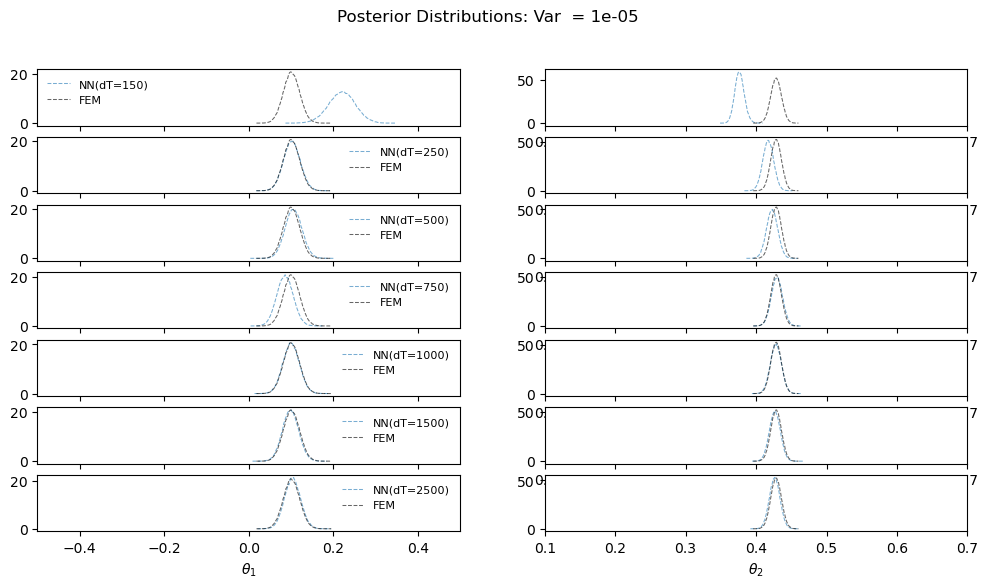

In [6]:
bins =80
vr = 1e-5
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/MDNN_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    # sample = np.load(f'./results/dGaLA_s{nobs}_noise{vr}.npy')

    # bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    # axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    # bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    # axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_pyro_h{hvert}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    #axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    #axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

In [ ]:


# Solve the FEM problem using the given theta values and roots
solver = FEMSolver(theta_th,vert=vert)
solution = solver.solve()

# Extract observation points and the solution points
obs_points, sol_points = solver.solution_array()

# Choose indices for the observation points, including start and end
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)

# Select the observation and solution points based on the indices
sol_points = solver.eval_at_points(obs_points)

# Generate noise and add it to the solution points
noise_sol_points = add_noise(sol_points, mean, std)

# Ensure proper reshaping of observation and solution points
obs_points = obs_points.reshape(-1, 1)
sol_test = noise_sol_points.reshape(-1, 1)


def add_noise(solution, mean, std, seed = 0):
    """
    Adds Gaussian noise to the solution.
    """
    rng = np.random.default_rng(seed)
    noise = rng.normal(mean, std, solution.shape)
    return solution + noise


In [19]:
rng = np.random.default_rng(0)
noise = rng.normal(0, 10**(-k/2), dy)
noise

array([ 0.0012573 , -0.00132105,  0.00640423,  0.001049  , -0.00535669,
        0.00361595])

In [20]:
dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)
eta

array([ 0.01764052,  0.00400157,  0.00978738,  0.02240893,  0.01867558,
       -0.00977278])

In [ ]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC


from MetropolisHastings import MetropolisHastingsSampler,MoreauYosidaPrior
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import matplotlib.pyplot as plt

from NN import DNN
from GaLa import llaplace
from GaLa2 import llaplace as llaplace2

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Computing Roots

In [5]:
lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [2.15374797 4.57785946]


In [11]:
def k_function(data_domain,w=roots):
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    data_domain = data_domain.requires_grad_(True)

    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        #retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        #retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

WRF_MDNN.de = de
WRF_MDNN.bc_l = bc_l
WRF_MDNN.bc_r = bc_r

WRFNN.de = de
WRFNN.bc_l = bc_l
WRFNN.bc_r = bc_r

MDNN.de = de
MDNN.bc_l = bc_l
MDNN.bc_r = bc_r

In [12]:
def generate_data(size, param = None, nparam = 2, seed = 65647437836358831880808032086803839626):
        #x = lhs(1, size).reshape(-1, 1)  # Latin Hypercube Sampling for x
        sampler = qmc.LatinHypercube(d=1, seed=seed)
        x = sampler.random(n=size)

        if param is None:
            param = samples_param(size=size, nparam= nparam)
        else:
            param = param[:size,:]

        x_tensor = torch.Tensor(x)
        param_tensor = torch.Tensor(param)

        data_int = torch.cat([x_tensor, param_tensor], axis=1).float()
        left_bc = torch.cat([torch.zeros_like(x_tensor).float(), param_tensor], axis=1).float()
        right_bc = torch.cat([torch.ones_like(x_tensor).float(), param_tensor], axis=1).float()

        return data_int, left_bc, right_bc  

In [13]:
def compute_loss(pinn, data_int, left_bc, right_bc, loss_fn):
    """Compute the total loss for given data."""
    pde_pred = pinn.de(data_int)
    left_bc_pred = pinn.bc_l(left_bc)
    right_bc_pred = pinn.bc_r(right_bc)

    zeros = torch.zeros_like(pde_pred)

    loss_pde = loss_fn(pde_pred, zeros)
    loss_lbc = loss_fn(left_bc_pred, zeros)
    loss_rbc = loss_fn(right_bc_pred, zeros)

    total_loss = loss_pde + loss_lbc + loss_rbc
    return total_loss, loss_pde, loss_lbc, loss_rbc


In [19]:
# Number of observations
epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 

layers = [3] + 4*[256] + [1]

models = {"NN":DNN(layers),
          "WRF_MDNN":WRF_MDNN(num_layers=4, hidden_dim=256, out_dim=1, activation="tanh", 
            fourier_emb=None, input_dim=3, reparam={"type":"weight_fact", "mean": 1.0, "stddev":0.1}),
          "WRF":WRFNN(layers),
          "MDNN":MDNN(num_layers=4, hidden_dim=256, out_dim=1, activation="tanh", 
            fourier_emb=None, input_dim=3)}

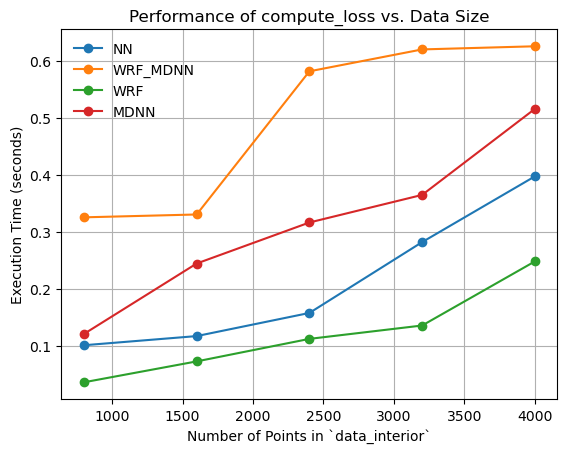

In [20]:
import time
import matplotlib.pyplot as plt

loss_fn = torch.nn.MSELoss(reduction ='mean')

sizes = [16*i for i in range(50,300,50)]  # Varying number of points in `data_interior`
times = {"NN":[],"WRF_MDNN":[],"WRF":[],"MDNN":[]}

for model in models.keys():
    for size in sizes:
        data_int, left_bc, right_bc   = generate_data(size=size)

        start_time = time.time()
        total_loss, _, _,_ = compute_loss(models[model], data_int, left_bc, right_bc,loss_fn)
        end_time = time.time()
        times[model].append(end_time - start_time)

# Plot Results
for model in models.keys():
    plt.plot(sizes, times[model], marker='o',label = model)

plt.xlabel('Number of Points in `data_interior`')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of compute_loss vs. Data Size')
plt.legend(frameon = False)
plt.grid(True)
plt.show()

In [ ]:
# torch.manual_seed(42)

# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization

# dataset = dGDataset(size = 2500, param=param_train)

# x_val,param_val, sol_val = generate_test_data(2500,param =param_test, vert=30)

# dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

# loss = torch.nn.MSELoss(reduction ='mean')

# for name,model in models.items():

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model {name}")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/{name}_train_N{2500}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/{name}_test_N{2500}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

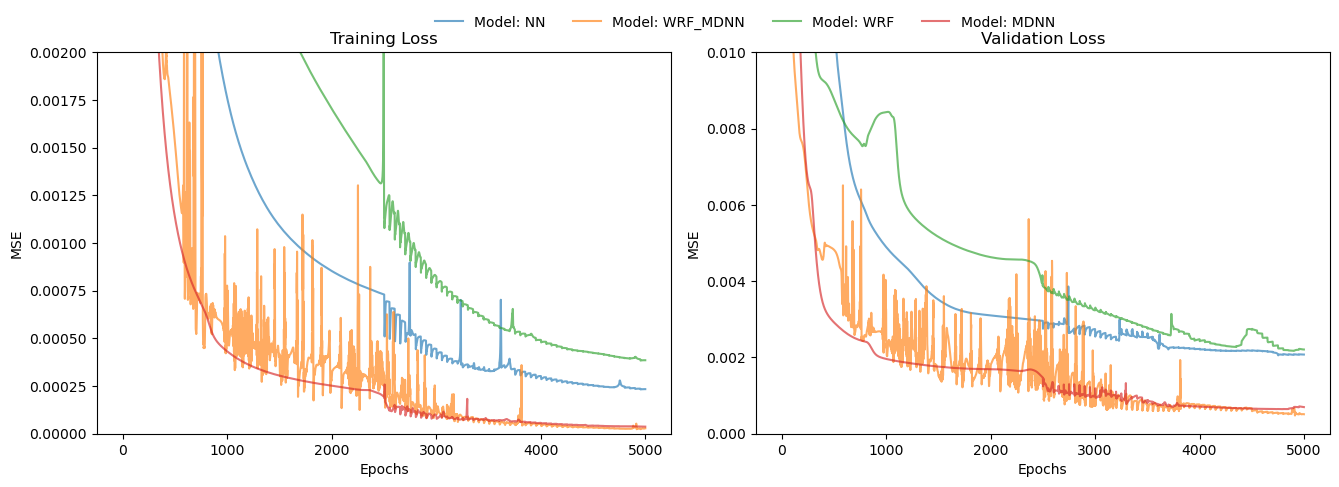

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5 ))

for name in models.keys():
# Loop through each batch size in sample_size
    # Load the data for ADAM optimizer (training and validation loss)
    adam_train_loss = np.load(f'./Models/{name}_train_N{2500}_batch{150}.npy')
    adam_test_loss = np.load(f'./Models/{name}_test_N{2500}_batch{150}.npy')

    # Plot Training Loss for ADAM optimizer
    axs[0].plot(adam_train_loss, label=f"Model: {name}", alpha = 0.65)
    axs[0].set_title(f"Training Loss")
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim(0,0.002)

    # Plot Validation Loss for ADAM optimizer
    axs[1].plot(adam_test_loss, label=f"Model: {name}", alpha = 0.65)
    axs[1].set_title(f"Validation Loss")
    axs[1].set_ylabel("MSE")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylim(0,0.01)
# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(models.keys()), frameon=False, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])


In [7]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid, len(models.keys())))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z, (name, model) in enumerate(models.items()):

            model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
            model.load_state_dict(torch.load(model_path))
            model.eval()

            surg = model(data).detach().cpu().numpy().reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - surg))
            results[i, j, z] = max_error

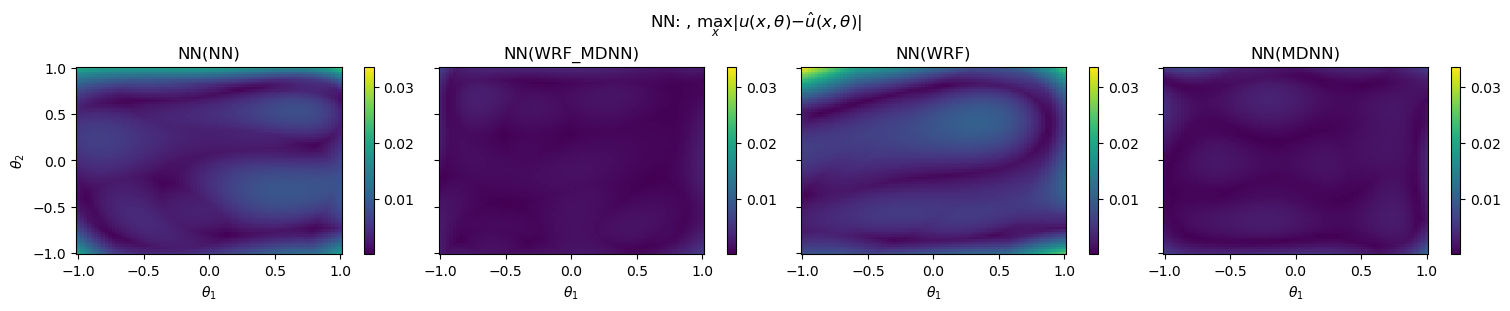

[0.00493473 0.00114548 0.00554597 0.00144679]


In [8]:
plot_max_errors(list(models.keys()), results, X, Y, "")

print(results.mean(axis=(0,1)))

In [9]:
for z, (name, model) in enumerate(models.items()):

    model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()

    total_params = sum(p.numel() for p in model.parameters())

    print(f"Total parameters model {name}: {total_params}")

Total parameters model NN: 521
Total parameters model WRF_MDNN: 762
Total parameters model WRF: 521
Total parameters model MDNN: 681


In [10]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [11]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [12]:
torch.set_rng_state(original_state_pytorch)


theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))

# #obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

# obs_points, obs_sol = torch.tensor(X), torch.tensor(y)
# # Define the MCMC kernel (using Random Walk Metropolis)

# st = torch.sqrt(torch.tensor(vr).float().to(device))    
# # Define the MCMC kernel (using Random Walk Metropolis)

# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))

# for z, (name, model) in enumerate(models.items()):

#     model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
#     model.load_state_dict(torch.load(model_path))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/{name}_var{vr}_{2500}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

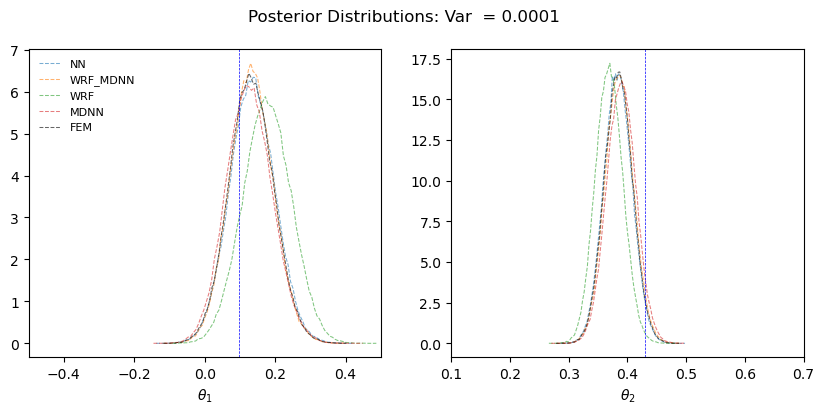

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")
bins =80
hvert = 50
vr = 1e-4


for name in models.keys():
    sample = np.load(f'./Models/{name}_var{vr}_{2500}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"{name}")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"{name}")


sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{10}_tiaming.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")

axs[0].legend(frameon = False, fontsize =8)
axs[0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
axs[1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

axs[1].set_xlim((0.1,0.7)),axs[0].set_xlim((-0.5,0.5))

axs[0].set_xlabel("$\\theta_{1}$"),axs[1].set_xlabel("$\\theta_{2}$")


# Experiment with DNN

In [12]:
# Number of observations
epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 

layers = [3] + 2*[20] + [1]

N = [150,250,500,750,1000,1500,2500]


In [ ]:
# torch.manual_seed(42)

# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization
# for nobs in N:
#     dataset = dGDataset(size = nobs, param=param_train)

#     x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)


#     dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

#     loss = torch.nn.MSELoss(reduction ='mean')

#     model = DNN(layers)

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model {DNN}")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/DNN_train_N{nobs}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/DNN_test_N{nobs}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

Starting Adam Training for model <class 'NN.DNN'>
Epoch 0, Train Loss: 1.03630e+01, Test Loss: 1.12188e+00
Epoch 10, Train Loss: 7.99600e+00, Test Loss: 8.12223e-01
Epoch 20, Train Loss: 6.51100e+00, Test Loss: 5.53472e-01
Epoch 30, Train Loss: 5.70183e+00, Test Loss: 3.92574e-01
Epoch 40, Train Loss: 5.25593e+00, Test Loss: 3.30222e-01
Epoch 50, Train Loss: 4.89157e+00, Test Loss: 2.99905e-01
Epoch 60, Train Loss: 4.54807e+00, Test Loss: 2.80937e-01
Epoch 70, Train Loss: 4.23809e+00, Test Loss: 2.72651e-01
Epoch 80, Train Loss: 3.96119e+00, Test Loss: 2.71822e-01
Epoch 90, Train Loss: 3.69454e+00, Test Loss: 2.73274e-01
Epoch 100, Train Loss: 3.39434e+00, Test Loss: 2.69844e-01
Epoch 110, Train Loss: 3.01979e+00, Test Loss: 2.58258e-01
Epoch 120, Train Loss: 2.56949e+00, Test Loss: 2.39003e-01
Epoch 130, Train Loss: 2.11276e+00, Test Loss: 2.15790e-01
Epoch 140, Train Loss: 1.76438e+00, Test Loss: 1.92144e-01
Epoch 150, Train Loss: 1.54619e+00, Test Loss: 1.70261e-01
Epoch 160, Train 

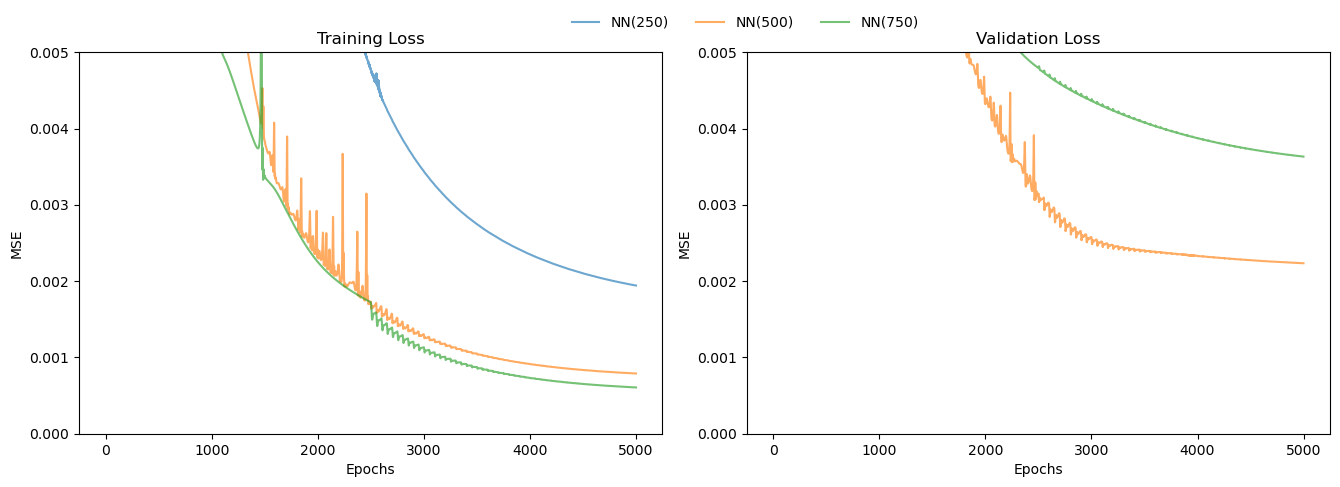

In [8]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5 ))

for nobs in N:
# Loop through each batch size in sample_size
    # Load the data for ADAM optimizer (training and validation loss)
    adam_train_loss = np.load(f'./Models/DNN_train_N{nobs}_batch{150}.npy')
    adam_test_loss = np.load(f'./Models/DNN_test_N{nobs}_batch{150}.npy')

    # Plot Training Loss for ADAM optimizer
    axs[0].plot(adam_train_loss, label=f"NN({nobs})", alpha = 0.65)
    axs[0].set_title(f"Training Loss")
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim(0,0.005)

    # Plot Validation Loss for ADAM optimizer
    axs[1].plot(adam_test_loss, label=f"NN({nobs})", alpha = 0.65)
    axs[1].set_title(f"Validation Loss")
    axs[1].set_ylabel("MSE")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylim(0,0.005)
# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(models.keys()), frameon=False, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

In [18]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid, len(models.keys())))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z, nobs in enumerate(N):

            model_path =  f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"
            model = DNN(layers)
            model.load_state_dict(torch.load(model_path))
            model.eval()

            surg = model(data).detach().cpu().numpy().reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - surg))
            results[i, j, z] = max_error

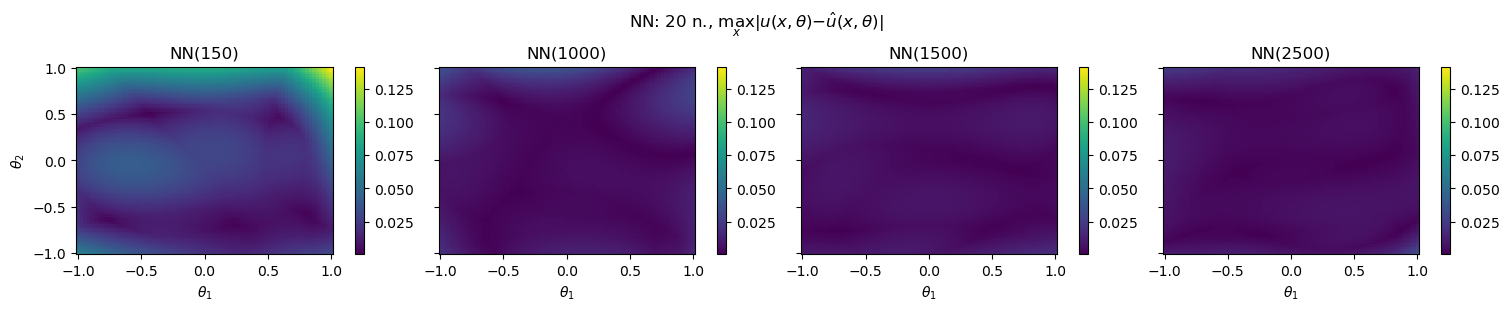

[0.02875376 0.00741002 0.00626378 0.00505031]


In [19]:
plot_max_errors(N, results, X, Y, "20 n.")

print(results.mean(axis=(0,1)))

# deepGaLA

In [11]:
nobs, hl, w = 500, 2, 20

layers = [3] + 2*[20] + [1]

model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{hl}_w{w}_N{nobs}_batch150.pt"))
model.eval()

##### Deep GaLA

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}

llp2 = llaplace2(model)

llp2.fit(pde=pde, hessian_structure = "full")

In [27]:
prior_list =[]
sigma_list = []
prior = 1
sigma  = 1
error_tolerance=1e-12
max_iter=500
lr=1e-2

log_prior  = torch.ones(prior, requires_grad=True)
log_sigma = torch.ones(sigma, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=lr)

error,n_iter = float('inf'),0  # Initialize error

while error > error_tolerance and n_iter < max_iter:
    prev_log_prior, prev_log_sigma = log_prior.detach().clone(), log_sigma.detach().clone()

    prior_list.append(prev_log_prior)
    sigma_list.append(prev_log_sigma)

    hyper_optimizer.zero_grad()

    # Calculate negative marginal likelihood
    neg_marglik = -llp2.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)

    # Perform optimization step
    hyper_optimizer.step()

    # Calculate the error based on the change in hyperparameters
    error = 0.5 * (torch.abs(log_prior - prev_log_prior) + torch.abs(log_sigma - prev_log_sigma)).item()

    n_iter += 1

    # Optional: log progress for monitoring
    if n_iter % 100 == 0:
        print(f"Iteration {n_iter}, Error: {error:.5f}, neg_marglik: {neg_marglik.item():.5f}")

if n_iter == max_iter:
    print(f"Maximum iterations ({max_iter})reached.")
print(f"Sigma : {llp2.sigma_noise.item()}, Prior: {llp2.prior_precision.item()}.")

Iteration 100, Error: 0.00852, neg_marglik: 526.95911
Iteration 200, Error: 0.00501, neg_marglik: 145.11911
Iteration 300, Error: 0.00125, neg_marglik: 27.35854
Iteration 400, Error: 0.00003, neg_marglik: 25.18629
Sigma : 0.22326579689979553, Prior: 11.632596015930176.


Text(0.5, 1.0, 'Sigma ($\\sigma$)')

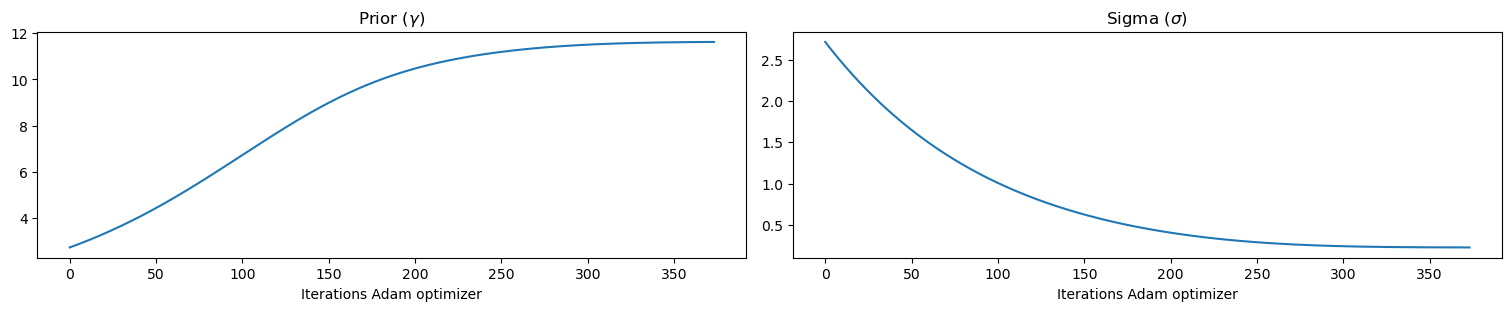

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), layout="constrained")

axs[0].set_title("Prior ($\gamma$)")
axs[0].set_xlabel("Iterations Adam optimizer")
axs[0].plot(np.exp(np.array(prior_list)))
axs[1].plot(np.exp(np.array(sigma_list)))
axs[1].set_xlabel("Iterations Adam optimizer")
axs[1].set_title("Sigma ($\sigma$)")

In [40]:
laplace_models  = dict()

layers = [3] + 2*[20] + [1]

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]


for nobs in N:

    model = DNN(layers).to(device)
    model.load_state_dict(torch.load(f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"))
    model.eval()

    ##### Deep GaLA
    data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

    pde = {"PDE":["de","bc_l","bc_r"], 
        "data_set":{"de" : Variable(data_int,requires_grad=True),
        "bc_l":left_bc,
        "bc_r" :right_bc}}

    llp2 = llaplace2(model)

    llp2.fit(pde=pde, hessian_structure = "full")

    llp2.optimize_marginal_likelihood(max_iter=300)

    laplace_models[str(nobs)] = llp2

Iteration 100, Error: 0.00913, neg_marglik: 50.15748
Iteration 200, Error: 0.00526, neg_marglik: -31.48352
Iteration 100, Error: 0.00923, neg_marglik: 22.37305
Iteration 200, Error: 0.00685, neg_marglik: -905.76587
Iteration 300, Error: 0.00366, neg_marglik: -1555.72974
Maximum iterations (300)reached, sigma : 0.059950608760118484, prior: 6.120851993560791.
Iteration 100, Error: 0.00936, neg_marglik: -10.87695
Iteration 200, Error: 0.00734, neg_marglik: -1458.69104
Iteration 300, Error: 0.00472, neg_marglik: -2693.94653
Maximum iterations (300)reached, sigma : 0.05437938868999481, prior: 6.873943328857422.
Iteration 100, Error: 0.00860, neg_marglik: -79.00750
Iteration 200, Error: 0.00573, neg_marglik: -2513.19141
Iteration 300, Error: 0.00439, neg_marglik: -4661.87061
Maximum iterations (300)reached, sigma : 0.053507000207901, prior: 3.9860169887542725.


In [41]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid,len(N)))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z,nobs in enumerate(N):
            llp = laplace_models[str(nobs)]

            u_mean, u_sigma = llp(data)
            
            u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].detach().cpu().numpy()

            #Compute the maximum error between FEM and surrogate
            mean_var = np.mean(u_sigma)
            results[i, j,z] = mean_var


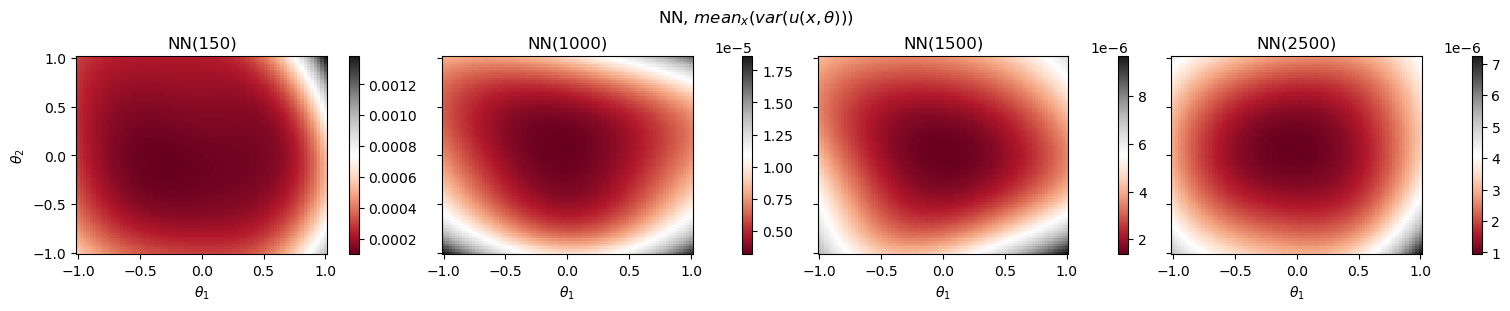

In [42]:
fig, axs = plt.subplots(1, len(N), figsize=(15, 3), layout="constrained", sharey=True)
fig.suptitle(fr"NN, $mean_{{x}} (var (u(x, \theta)))$", fontsize=12)

z_min, z_max = results.min(), results.max()

for z, key in enumerate(N):
    Z = results[:, :, z]  # Extract the results for current N

    # Set the color scale limits based on the first plot
    # Plot the heatmap for each N
    pcm = axs[z].pcolormesh(X, Y, Z, shading='auto', cmap = "RdGy")
    axs[z].set_xlabel(r"$\theta_1$")
    axs[z].set_title(f"NN({key})")
    plt.colorbar(pcm, ax=axs[z])

axs[0].set_ylabel(r"$\theta_2$")  # Set common y-axis label
plt.show()


# Pyro Uniform

# Inverse problem through MCMC

In [9]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from elliptic_files.FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1).float()

    surg_mu = surrogate.u(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [10]:
obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-4),
                                            theta_t=np.array([0.098, 0.430]),
                                            vert=50)

In [19]:
model = torch.load(f"./models/MDNN_s150.pth")
model.eval()

kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

mcmc_sampler.run(model,torch.tensor(sol_test),torch.tensor(obs_points),np.sqrt(1e-4))

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

Sample: 100%|██████████| 1005000/1005000 [08:17, 2019.73it/s, step size=1.31e-01, acc. prob=0.229]


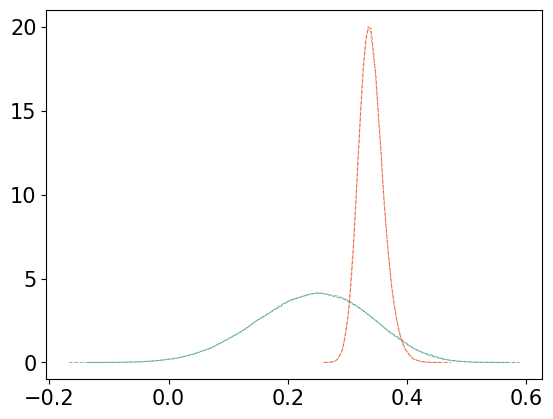

In [20]:
bin_centers, counts = histogram_(samples[:, 0],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
bin_centers, counts = histogram_(samples[:, 1],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

sample = np.load(f'./results/NN_ss{150}_var{vr}.npy')
bin_centers, counts = histogram_(sample[:, 0],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")


In [10]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
#eta = np.random.normal(0,10**(-k/2),dy)
eta = np.random.normal(0,np.sqrt(1e-4),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])

y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [ ]:

theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
hvert = 50

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

#obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

obs_points, obs_sol = torch.tensor(X), torch.tensor(y)
# Define the MCMC kernel (using Random Walk Metropolis)

st = torch.sqrt(torch.tensor(vr).float().to(device))    
# # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=hvert)

# # Run the MCMC inference
# mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# # Get the results (posterior samples)
# samples = mcmc_sampler.get_samples()
# samples = samples["theta"].numpy()

# np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy', samples)


# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))
# layers = [3] + 2*[20] + [1]

# for nobs in N:
#     model = DNN(layers).to(device)
#     model.load_state_dict(torch.load(f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

#     #### Deep GaLA
#     data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
#     data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


#     pde = {"PDE":["de","bc_l","bc_r"], 
#         "data_set":{"de" : Variable(data_int,requires_grad=True),
#         "bc_l":left_bc,
#         "bc_r" :right_bc}}
    
#     llp2 = llaplace2(model)

#     start_time_mh = time.time()  # Start timing
#     llp2.fit(pde=pde, hessian_structure = "full")
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

#     start_time_mh = time.time()  # Start timing
#     llp2.optimize_marginal_likelihood()
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")
    
#     kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                      torch.tensor(obs_points).float().to(device),
#                      torch.sqrt(torch.tensor(vr).float().to(device)))

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [06:33, 2556.68it/s, step size=1.28e-01, acc. prob=0.222]


Total time for fitting: 0.004777284463246664
Iteration 100, Error: 0.00940, neg_marglik: 49.25685
Iteration 200, Error: 0.00691, neg_marglik: -151.03094
Iteration 300, Error: 0.00230, neg_marglik: -236.53088
Maximum iterations (300)reached, sigma : 0.07599138468503952, prior: 7.258443832397461.
Total time for optimizing: 0.01185534397761027


Sample: 100%|██████████| 1005000/1005000 [06:36, 2535.73it/s, step size=1.16e-01, acc. prob=0.239]


Total time for fitting: 0.014604139328002929
Iteration 100, Error: 0.00919, neg_marglik: 44.78545
Iteration 200, Error: 0.00669, neg_marglik: -408.53671
Iteration 300, Error: 0.00350, neg_marglik: -717.36493
Maximum iterations (300)reached, sigma : 0.0607309564948082, prior: 5.857875347137451.
Total time for optimizing: 0.011999861399332682


Sample: 100%|██████████| 1005000/1005000 [06:40, 2512.38it/s, step size=1.16e-01, acc. prob=0.240]


Total time for fitting: 0.03333561023076375
Iteration 100, Error: 0.00933, neg_marglik: 37.94294
Iteration 200, Error: 0.00719, neg_marglik: -663.48517
Iteration 300, Error: 0.00413, neg_marglik: -1192.85095
Maximum iterations (300)reached, sigma : 0.05773898959159851, prior: 6.720389366149902.
Total time for optimizing: 0.01398795445760091


Sample: 100%|██████████| 1005000/1005000 [18:27, 907.52it/s, step size=1.19e-01, acc. prob=0.239]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

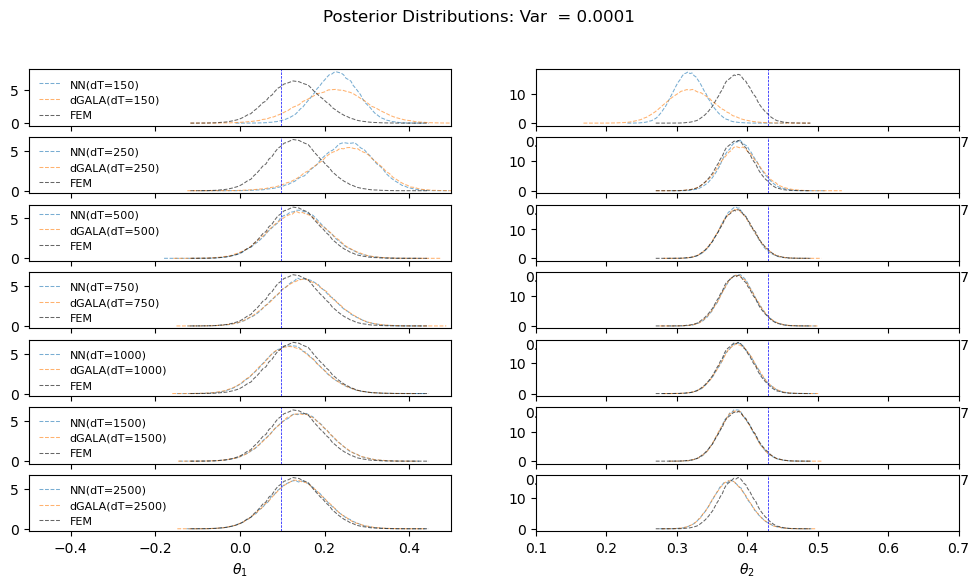

In [13]:
bins =80
vr = 1e-4

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

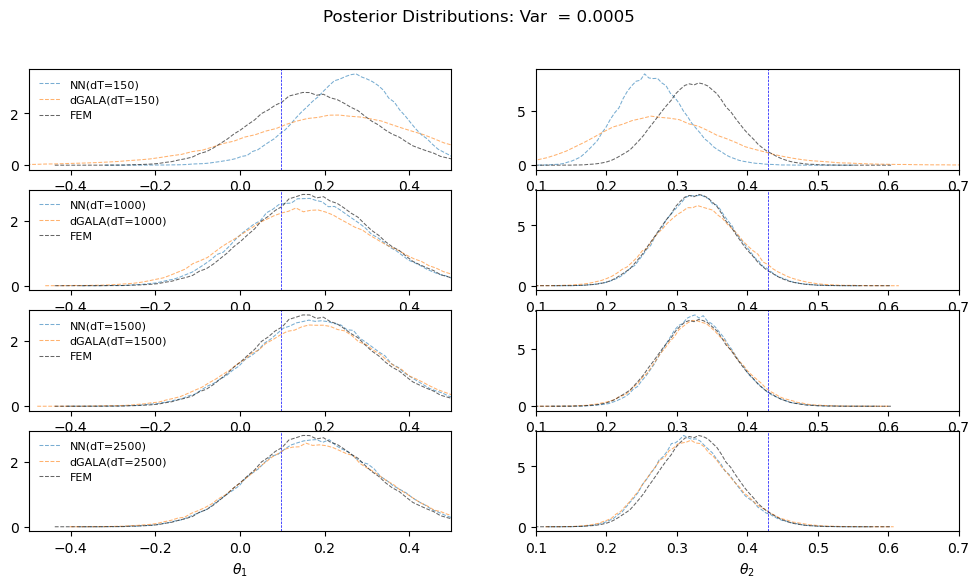

In [25]:
vr = 5e-4

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")
bins =80

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    

    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



# Modified DNN


In [18]:
#torch.manual_seed(42)

epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 
N = [150,250,500,750,1000,1500,2500]
# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization
# for nobs in N:
#     dataset = dGDataset(size = nobs, param=param_train)

#     x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)

#     dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

#     loss = torch.nn.MSELoss(reduction ='mean')

#     model = MDNN()

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model WRF_linear ouput")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/MDNN_train_N{nobs}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/MDNN_test_N{nobs}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_MDNN_N{nobs}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

In [15]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [16]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
#eta = np.random.normal(0,10**(-k/2),dy)
eta = np.random.normal(0,np.sqrt(1e-4),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])

y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [ ]:

theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
hvert = 50

# #obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)
# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# obs_points, obs_sol = torch.tensor(X), torch.tensor(y)

# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))
# # layers = [3] + 2*[20] + [1]

# for nobs in N:
#     model = MDNN().to(device)
#     model.load_state_dict(torch.load( f"./Models/1dElliptic_MDNN_N{nobs}_batch{150}.pt"))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/MDNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

#     #### Deep GaLA
#     data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
#     data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

#     pde = {"PDE":["de","bc_l","bc_r"], 
#         "data_set":{"de" : Variable(data_int,requires_grad=True),
#         "bc_l":left_bc,
#         "bc_r" :right_bc}}
    
#     llp2 = llaplace2(model)

#     start_time_mh = time.time()  # Start timing
#     llp2.fit(pde=pde, hessian_structure = "full")
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

#     start_time_mh = time.time()  # Start timing
#     llp2.optimize_marginal_likelihood(max_iter=200)
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")
    
#     kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                      torch.tensor(obs_points).float().to(device),
#                      torch.sqrt(torch.tensor(vr).float().to(device)))

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/dGaLA2_MDNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [07:28, 2242.54it/s, step size=1.19e-01, acc. prob=0.232]


Total time for fitting: 0.005243853727976481
Iteration 100, Error: 0.00975, neg_marglik: 49.10341
Iteration 200, Error: 0.00866, neg_marglik: -179.36710
Maximum iterations (200)reached, sigma : 0.13852646946907043, prior: 6.41798210144043.
Total time for optimizing: 0.017753207683563234


Sample: 100%|██████████| 1005000/1005000 [07:43, 2165.99it/s, step size=1.19e-01, acc. prob=0.226]


Total time for fitting: 0.019602620601654054
Iteration 100, Error: 0.00971, neg_marglik: 40.51773
Iteration 200, Error: 0.00863, neg_marglik: -441.68585
Maximum iterations (200)reached, sigma : 0.13705626130104065, prior: 6.254026412963867.
Total time for optimizing: 0.012525423367818197


Sample: 100%|██████████| 1005000/1005000 [07:38, 2193.83it/s, step size=1.15e-01, acc. prob=0.236]


Total time for fitting: 0.03338874975840251
Iteration 100, Error: 0.00966, neg_marglik: 28.09209
Iteration 200, Error: 0.00847, neg_marglik: -698.78186
Maximum iterations (200)reached, sigma : 0.13726752996444702, prior: 6.121282577514648.
Total time for optimizing: 0.011039698123931884


Sample: 100%|██████████| 1005000/1005000 [17:47, 941.16it/s, step size=1.27e-01, acc. prob=0.238]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

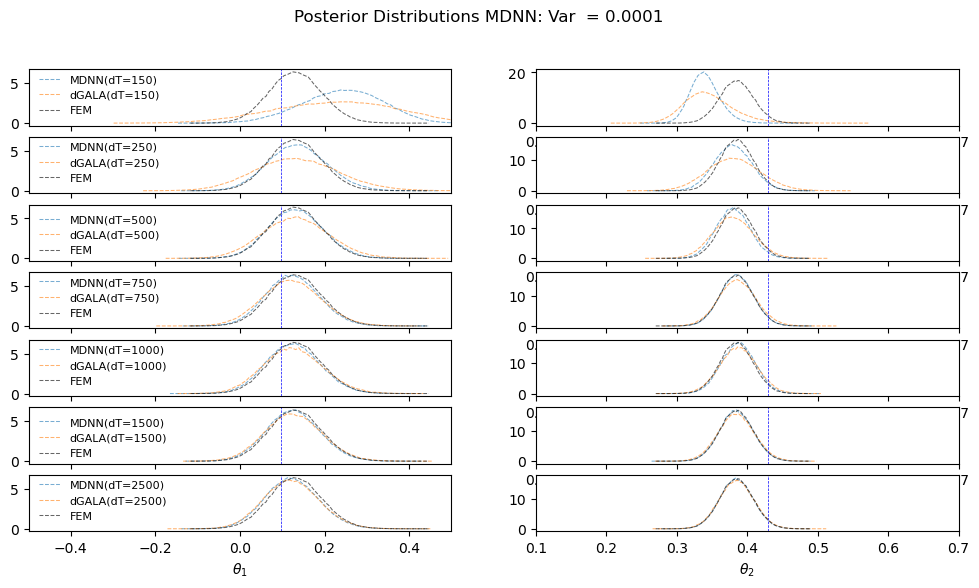

In [19]:
bins =80
vr = 1e-4
hvert = 50
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions MDNN: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/MDNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"MDNN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"MDNN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_MDNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

